In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import math
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# **Statistical models**

## **Load Time Series**

In [3]:
df = pd.read_excel('energy_demand.xlsx')
df.head()

Date  Hour    load          T
0 2012-01-01     0  2872.0  30.666667
1 2012-01-01     1  2698.0  32.000000
2 2012-01-01     2  2558.0  32.666667
3 2012-01-01     3  2444.0  30.000000
4 2012-01-01     4  2402.0  31.000000

In [4]:
df.tail()

Date  Hour    load          T
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

In [5]:
#Verificar o tipo de dados do nosso dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26305 non-null  datetime64[ns]
 1   Hour    26305 non-null  int64         
 2   load    26305 non-null  float64       
 3   T       26305 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.2 KB


In [6]:
#verificar se exitem valores nulos
df.isnull().sum()

Date    0
Hour    0
load    0
T       0
dtype: int64

In [7]:
# Verificar se existem duplicados
df.duplicated().sum()

0

In [8]:
# Combinar as colunas 'Date' e 'Hour' para criar um índice de data e hora
df['Datetime'] = df['Date'] + pd.to_timedelta(df['Hour'], unit='h')
df.head()

Date  Hour    load          T            Datetime
0 2012-01-01     0  2872.0  30.666667 2012-01-01 00:00:00
1 2012-01-01     1  2698.0  32.000000 2012-01-01 01:00:00
2 2012-01-01     2  2558.0  32.666667 2012-01-01 02:00:00
3 2012-01-01     3  2444.0  30.000000 2012-01-01 03:00:00
4 2012-01-01     4  2402.0  31.000000 2012-01-01 04:00:00

In [9]:
# Definir 'Datetime' como índice
df.set_index('Datetime', inplace=True)

# Eliminar as colunas 'Date' e 'Hour'
df.drop(['Date', 'Hour'], axis=1, inplace=True)
df.head()

load          T
Datetime                              
2012-01-01 00:00:00  2872.0  30.666667
2012-01-01 01:00:00  2698.0  32.000000
2012-01-01 02:00:00  2558.0  32.666667
2012-01-01 03:00:00  2444.0  30.000000
2012-01-01 04:00:00  2402.0  31.000000

In [10]:
# Atribuir a frequência da nossa serie temporal, nest caso hora
df = df.asfreq('H')

## **2. Visualize the time series.**

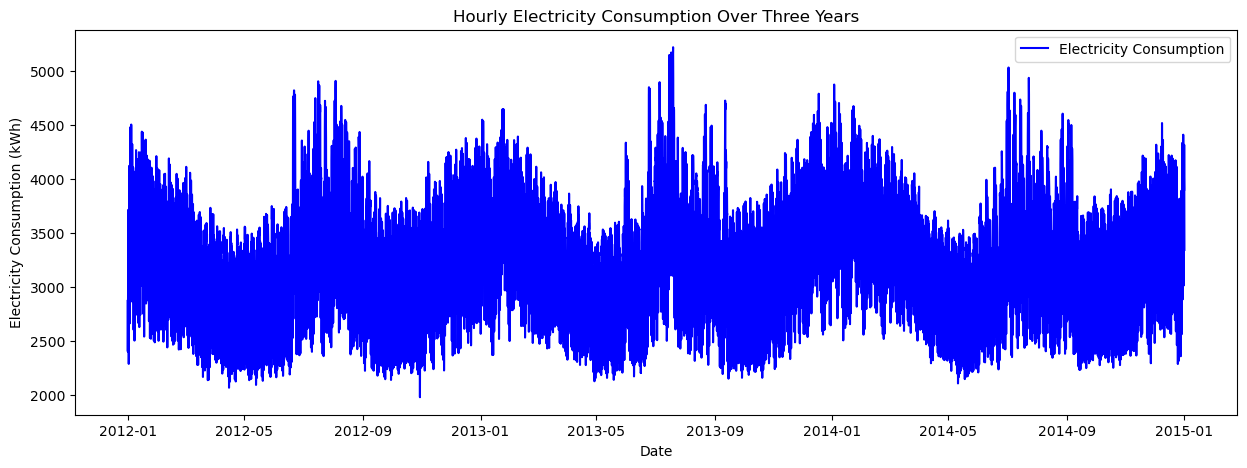

In [11]:
# Plot da série temporal de consumo de eletricidade
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['load'], label='Electricity Consumption', color='blue')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Hourly Electricity Consumption Over Three Years')
plt.legend()
plt.show()

### Como se tratam de registo à hora, pensamos que também seria interessante visualizar esta série temporal durante uma ano, mês e semana

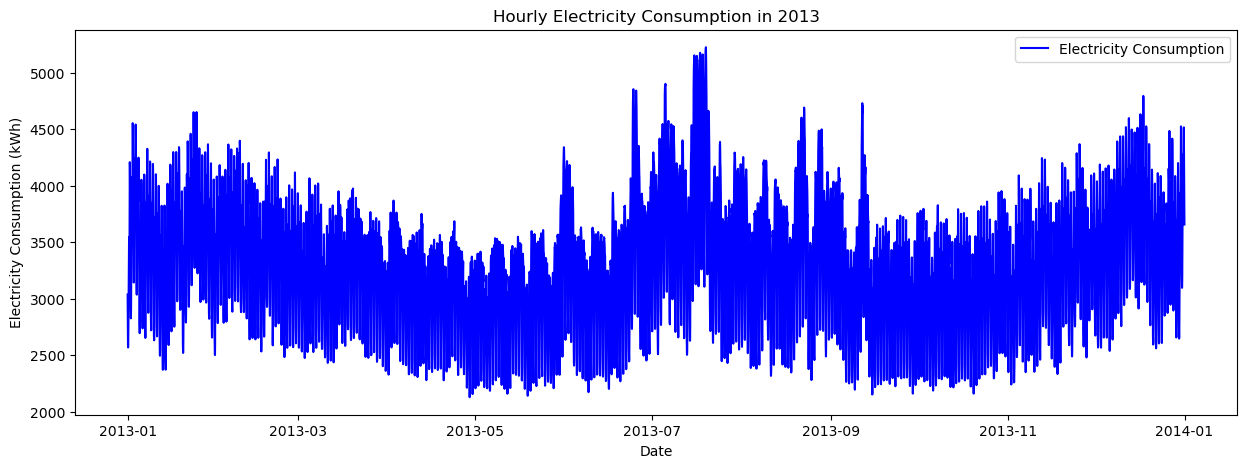

In [12]:
# Filtro dos dados para um ano específico (por exemplo, 2013)
df_2013 = df['2013']

# Plot da série temporal de consumo de eletricidade para 2013
plt.figure(figsize=(15, 5))
plt.plot(df_2013.index, df_2013['load'], label='Electricity Consumption', color='blue')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Hourly Electricity Consumption in 2013')
plt.legend()
plt.show()


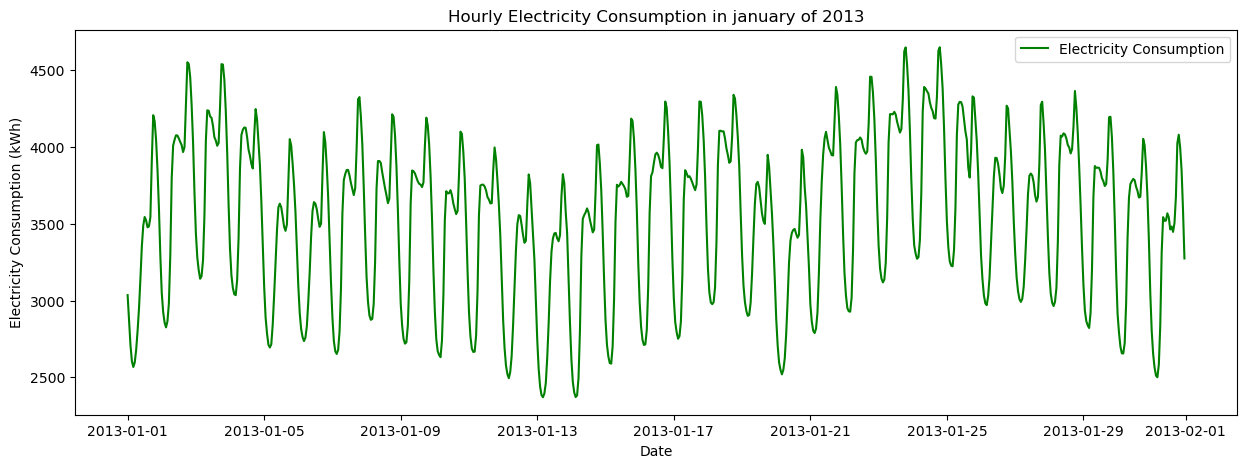

In [13]:
# Filtrando dados para um mês específico (por exemplo, 2013)
df_2013_01 = df['2013-01']

# Plot da série temporal de consumo de eletricidade para 2013
plt.figure(figsize=(15, 5))
plt.plot(df_2013_01.index, df_2013_01['load'], label='Electricity Consumption', color='green')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Hourly Electricity Consumption in january of 2013')
plt.legend()
plt.show()

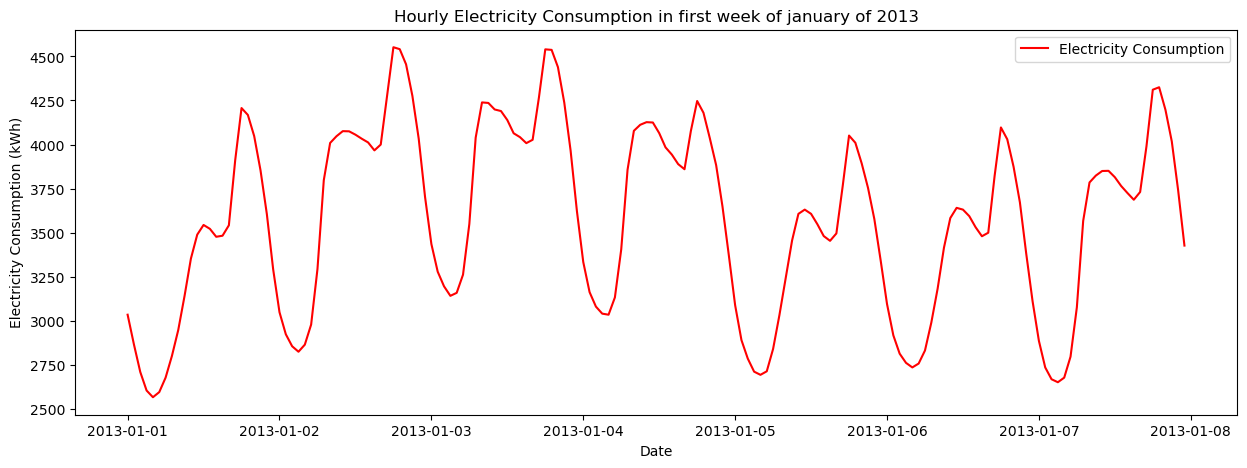

In [14]:
# Filtrando dados para uma semana específico (por exemplo, primeira semana de janeiro de 2013)
df_first_week_jan_2013 = df['2013-01-01':'2013-01-07']

# Plot da série temporal de consumo de eletricidade para a primeira semana de janeiro 2013
plt.figure(figsize=(15, 5))
plt.plot(df_first_week_jan_2013.index, df_first_week_jan_2013['load'], label='Electricity Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Hourly Electricity Consumption in first week of january of 2013')
plt.legend()
plt.show()


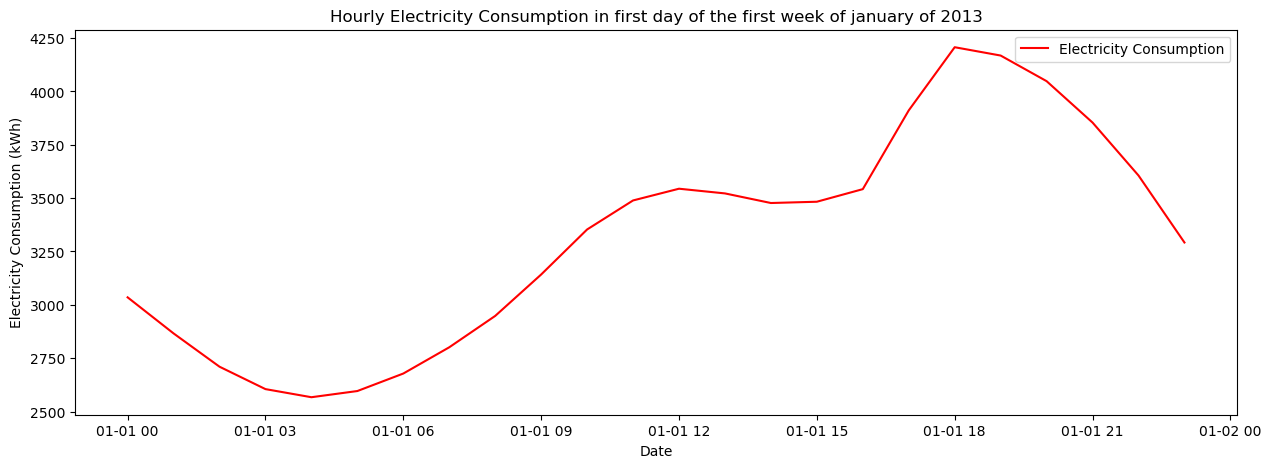

In [15]:
# Filtrando dados para um dia específico (por exemplo, primeiro dia da primeira semana de janeiro de 2013)
df_first_day_of_week_jan_2013 = df['2013-01-01']

# Plot da série temporal de consumo de eletricidade para o primeiro dia da primeira semana de janeiro 2013
plt.figure(figsize=(15, 5))
plt.plot(df_first_day_of_week_jan_2013.index, df_first_day_of_week_jan_2013['load'], label='Electricity Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Hourly Electricity Consumption in first day of the first week of january of 2013')
plt.legend()
plt.show()


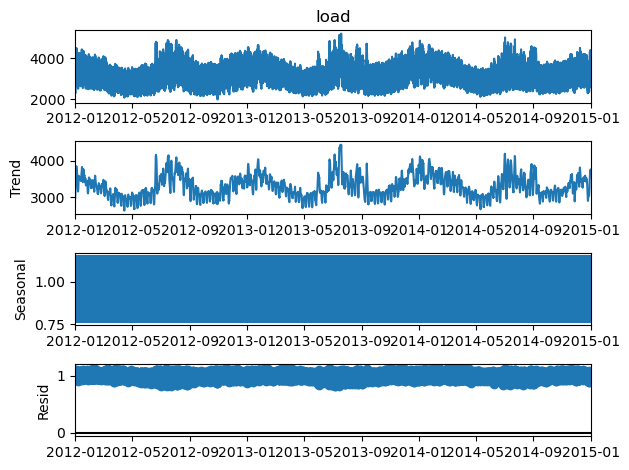

In [16]:
# Decomposição da série temporal de consumo de eletricidade
result_load = seasonal_decompose(df['load'], model='multiplicative', period=24)# Periodicidade diária (24 horas); Se você usasse o modelo aditivo, estariamos a assumir que o consumo de energia aumenta a cada ano em uma quantidade fixa, o que não acontece
# Gráficos da decomposição
result_load.plot()
plt.show()

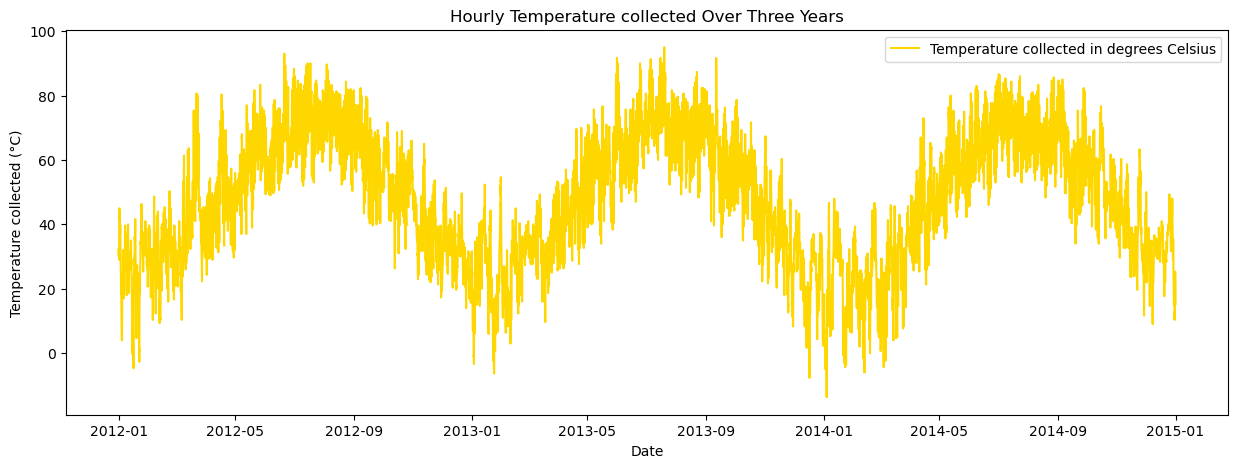

In [17]:
# Plot da série temporal de temperatura
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['T'], label='Temperature collected in degrees Celsius', color='gold')
plt.xlabel('Date')
plt.ylabel('Temperature collected (°C)')
plt.title('Hourly Temperature collected Over Three Years')
plt.legend()
plt.show()

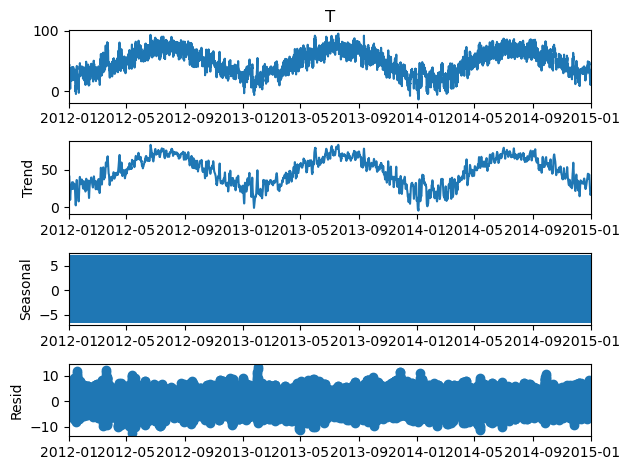

In [18]:
# Decomposição da série temporal de temperatura redistada
result_T = seasonal_decompose(df['T'], model='additive', period=24)# Periodicidade diária (24 horas);

result_T.plot()
plt.show()

#### "Before applying any statistical model on a time series, the series has to be stationary."</br>Então vamos determinar se esta série temporal é estacionária ou não.

### **Com a granularidade dos dados ao nível da hora é um pouco difícil visualizar os diferentes componentes (tendência, sazonalidade e padrões residuais), por isso vamos agregar os dados ao nivél mensal calculando a média dos dados relativamente a este periodo**

In [19]:
# Agregar por semana para calcular a média da carga de energia e da temperatura
df_semana = df.resample('w').mean()

df_semana.head()

load          T
Datetime                          
2012-01-01  2991.458333  37.208333
2012-01-08  3481.565476  25.902778
2012-01-15  3550.791667  23.773810
2012-01-22  3605.345238  19.045635
2012-01-29  3332.321429  34.440476

### Como agregamos os dados ao nivel mensal, vamos alterar a frequencia do index

In [20]:
# Ajustar a frequência do índice para mensal
df_semana.index.freq = 'W'

## **2. Visualizar a série temporal, com agregação ao mês.**

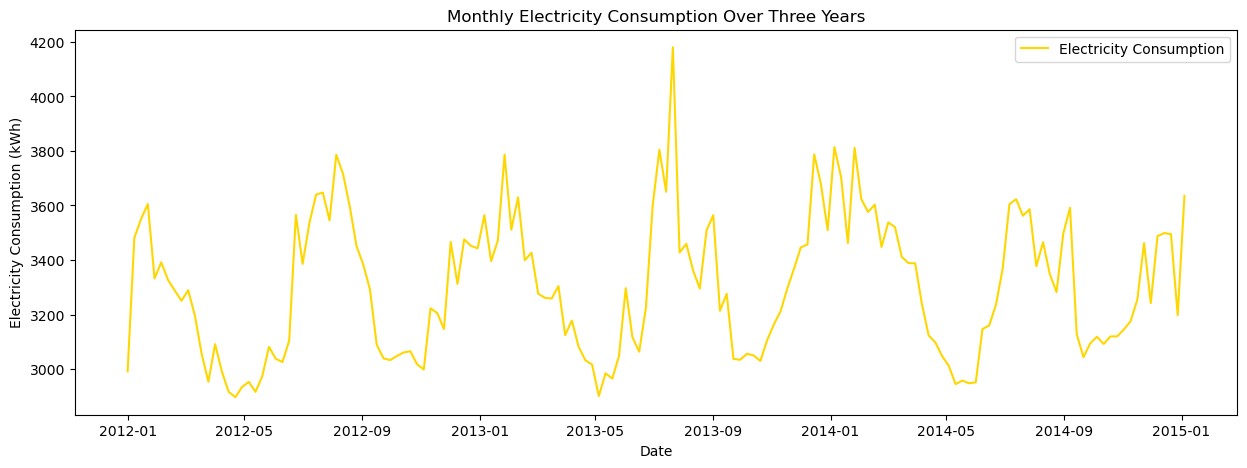

In [21]:
# Plot da série temporal de consumo de eletricidade
plt.figure(figsize=(15, 5))
plt.plot(df_semana.index, df_semana['load'], label='Electricity Consumption', color='gold')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.title('Monthly Electricity Consumption Over Three Years')
plt.legend()
plt.show()

### **Decomposição da série temporal**

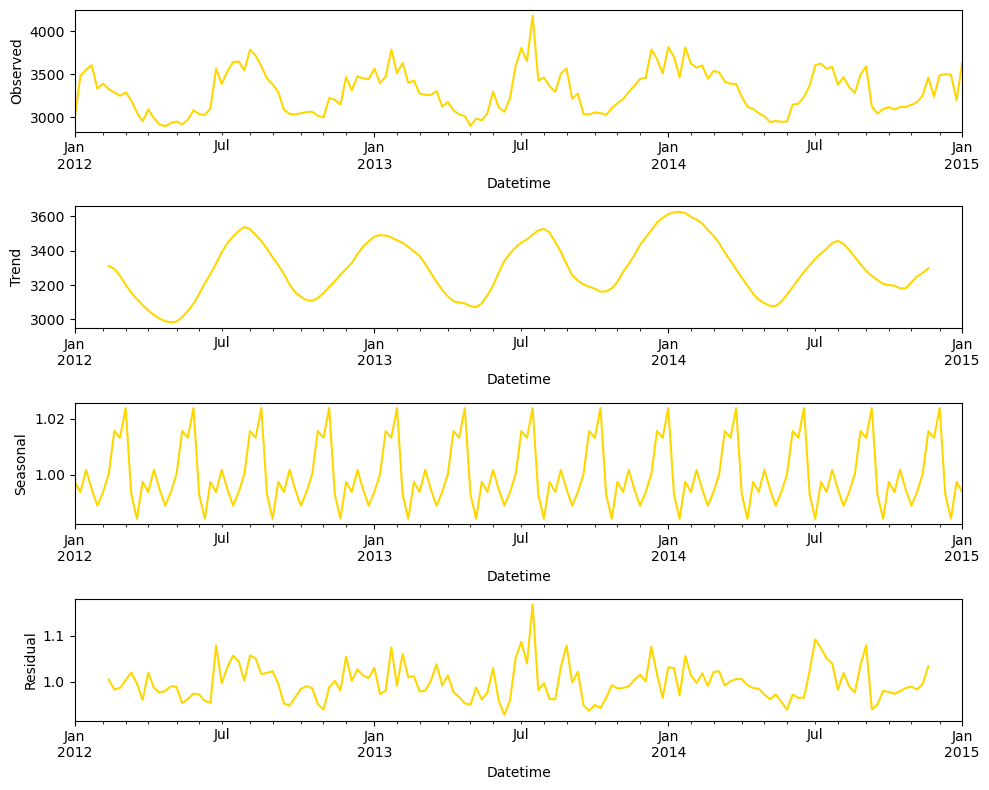

In [22]:
# Decomposição da série temporal de consumo de eletricidade
result_load = seasonal_decompose(df_semana['load'], model='multiplicative', period=12)# Periodicidade semanal (7 dias); 

# Gráficos da decomposição com cores personalizadas
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

result_load.observed.plot(ax=axes[0], legend=False, color='gold')  
axes[0].set_ylabel('Observed')

result_load.trend.plot(ax=axes[1], legend=False, color='gold') 
axes[1].set_ylabel('Trend')

result_load.seasonal.plot(ax=axes[2], legend=False, color='gold')  
axes[2].set_ylabel('Seasonal')

result_load.resid.plot(ax=axes[3], legend=False, color='gold')  
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

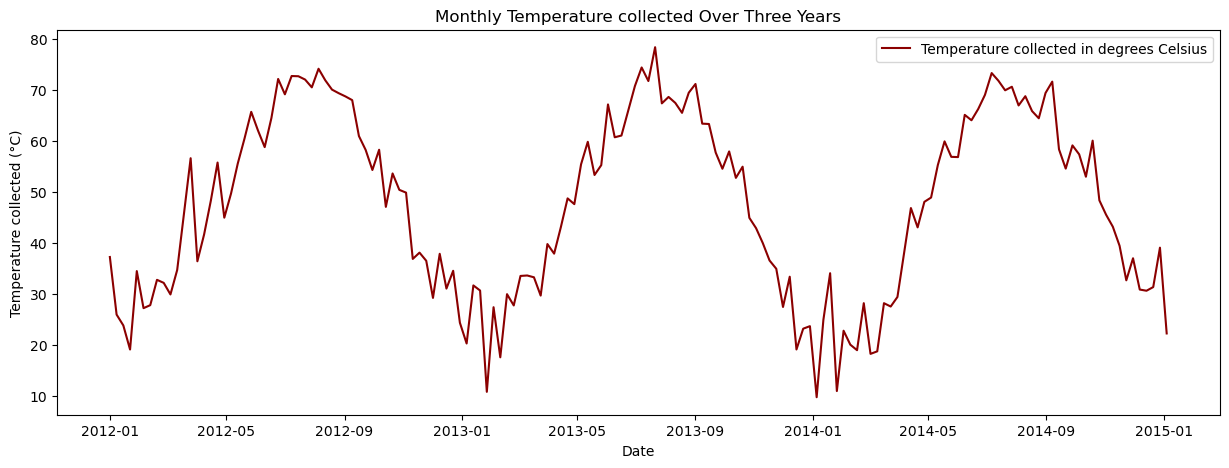

In [23]:
# Plot da série temporal de temperatura
plt.figure(figsize=(15, 5))
plt.plot(df_semana.index, df_semana['T'], label='Temperature collected in degrees Celsius', color='darkred')
plt.xlabel('Date')
plt.ylabel('Temperature collected (°C)')
plt.title('Monthly Temperature collected Over Three Years')
plt.legend()
plt.show()

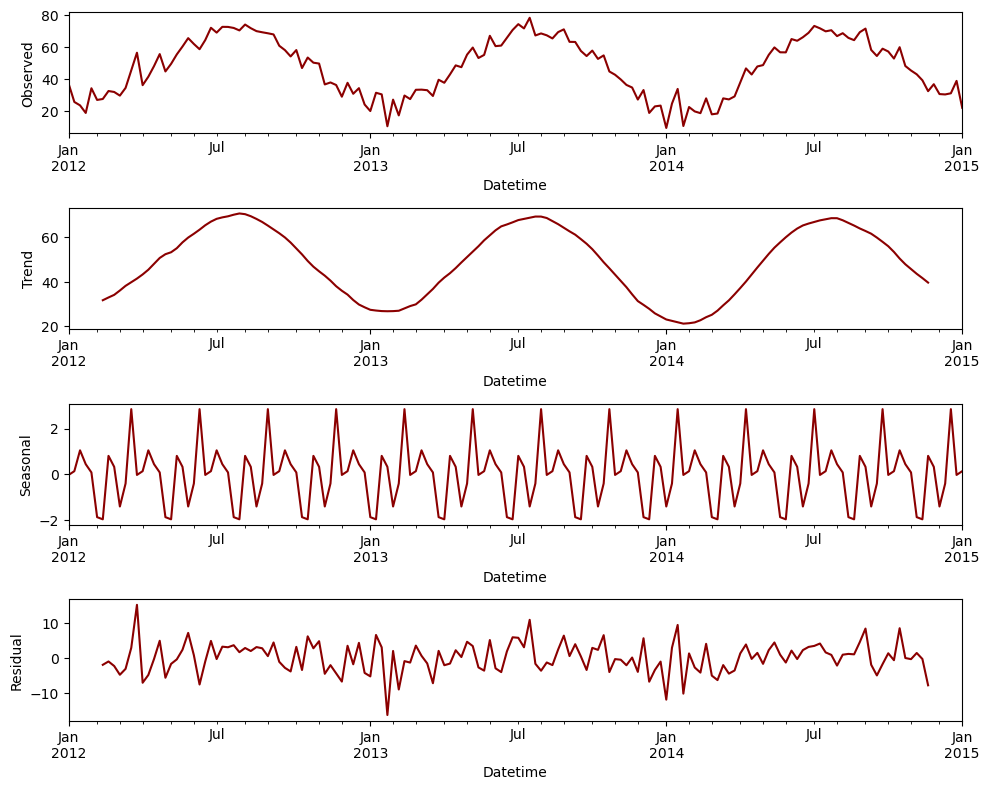

In [24]:
# Decomposição da série temporal de consumo de eletricidade
result_load = seasonal_decompose(df_semana['T'], model='adittive', period=12)# Periodicidade semanal
# Gráficos da decomposição com cores personalizadas
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

result_load.observed.plot(ax=axes[0], legend=False, color='darkred')  # Série observada em azul
axes[0].set_ylabel('Observed')

result_load.trend.plot(ax=axes[1], legend=False, color='darkred')  # Tendência em verde
axes[1].set_ylabel('Trend')

result_load.seasonal.plot(ax=axes[2], legend=False, color='darkred')  # Sazonalidade em vermelho
axes[2].set_ylabel('Seasonal')

result_load.resid.plot(ax=axes[3], legend=False, color='darkred')  # Resíduos em roxo
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Test to check if a series is stationary</br>**ADCF Test - Augmented Dickey–Fuller test**

In [25]:
#test for stationarity
ADF_result = adfuller(df_semana['load'])
print(f'ADF Statistic:{ADF_result[0]}')
print(f'p-value:{ADF_result[1]}')

ADF Statistic:-6.801864822902371
p-value:2.2265472897144813e-09


### p-value > 0.05 => time series **is stationary**<br>Como já é estacionária não precisamos de fazer qualquer tipo de tranformação (**Differencing**). E, como tal, não utilizaremos modelos como **ARIMA(p,d,q)**

## **Autocorrelation function (ACF) e ParCal AutocorrelaCon funcCon (PACF)**

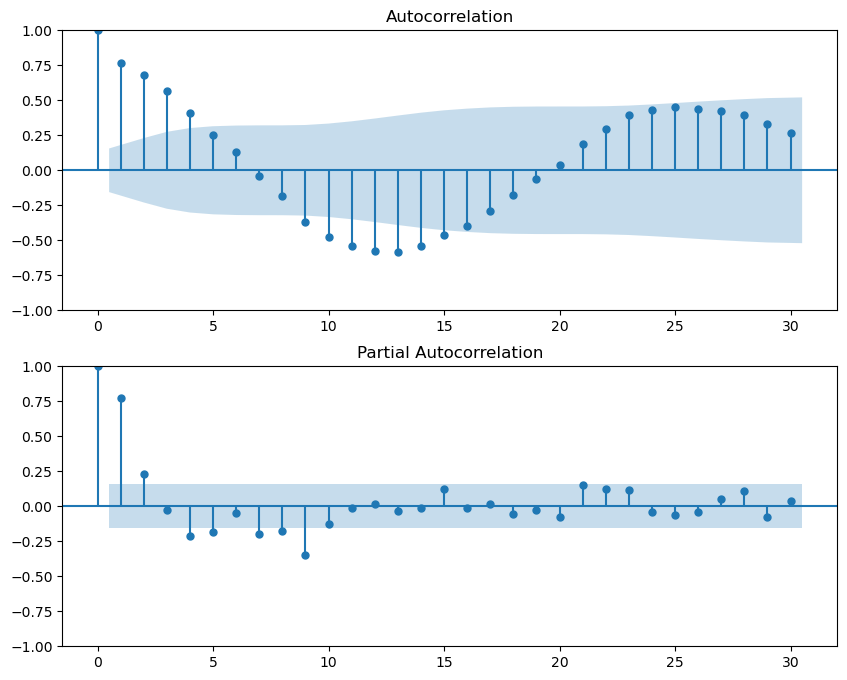

In [26]:
# Plotar ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_semana['load'], lags=30, ax=ax1)  # ACF
plot_pacf(df_semana['load'], lags=30, ax=ax2)  # PACF

plt.show()

### **Existe várias autocorrelações** afastadas de 0. Logo, esta série temporal não é uma **Random-Walk**

#### O gráfico ACF pode ser utilizado para identificar o número de *lags* necessários para um modelo de série temporal.

### A função de autocorrelação parKal pode ser usada para determinar a ordem de uma série AR(p) estacionária - os coeficientes não serão significativos após o atraso p.<br>Se o gráfico PACF permanecer significativo por vários lags, isso sugere que o processo é de ordem alta (AR(p) para algum valor de p).

### **Vamos interpretar esses resultados:**
#### **ACF:**<br>O decaimento gradual no ACF com significância nos primeiros lags (até 4) sugere uma possível componente AR inicial. Isso indica uma autocorrelação significativa nos primeiros lags, o que é comum em modelos AR. <br>A significância nos lags 10 a 15, seguido por um padrão insignificante ao longo dos lags seguintes, pode sugerir uma sazonalidade ou um padrão periódico na série temporal. Isso pode ser indicativo de um componente sazonal, o que é comum em modelos SARIMA.<br>Esta descrição parece ter características que podem ser associadas tanto a componentes AR quanto a possíveis efeitos sazonais, o que pode sugerir um modelo ARIMA sazonal ou um modelo SARIMA, como escolhas mais adequadas a esta série.
#### **PACF:**<br>Este padrão no PACF pode indicar um possível modelo autorregressivo (AR) com um termo significativo no lag 1 e possivelmente nos lags 2 e 9 (exceto 3 e 6), indicando uma possível ordem de 1 ou 2 para o componente AR.<br>Considerando esses resultados, a combinação dos padrões observados no ACF e PACF sugere um possível modelo ARIMA com um termo AR de ordem 1 ou 2 (p) e possivelmente termos MA de ordem 4 (q) com base no ACF.

### No entanto é importante testar os modelos e depois avaliar qual deles é que se adequa melhor ao nosso porblema.

## **4. Split the data in train and test sets.**

In [27]:
def split_data (df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [28]:
train_load, test_load = split_data(df_semana)
print(train_load.shape)
print(test_load.shape)

(135, 2)
(23, 2)


In [29]:
train_load.tail()

load          T
Datetime                          
2014-06-29  3368.392857  69.027778
2014-07-06  3604.803571  73.313492
2014-07-13  3623.214286  71.811508
2014-07-20  3562.285714  69.932540
2014-07-27  3586.130952  70.626984

In [30]:
test_load.head()

load          T
Datetime                          
2014-08-03  3377.654762  66.958333
2014-08-10  3465.327381  68.771825
2014-08-17  3348.244048  65.851190
2014-08-24  3282.178571  64.436508
2014-08-31  3496.678571  69.400794

# **ARMA(p,q)**

#### Se a série for um processo estacionário ARMA(p,q), tanto os gráficos ACF quanto os gráficos PACF mostram um padrão de decaimento ou sinusoidal.
##### Os gráficos ACF e PACF não podem ser usados para determinar as ordens q e p de um processo ARMA(p,q).<br>A solução é ajustar vários modelos ARMA(p,q) com várias combinações de valores para p e q e, em seguida, escolher um modelo usando os critérios de informação de Akaike.

### **A function to fit different ARMA(p,q) models and select the best one (with lowest AIC value)**

In [31]:
def optimize_ARMA(data, order_list):
    results=[]
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending orde, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [32]:
import itertools

# Definir uma lista de valores para p e q a serem testados
p_values = range(0, 5) 
q_values = range(0, 5)  

# Criar todas as combinações de p e q possíveis
pq_values = list(itertools.product(p_values, q_values))

print(pq_values)  # Exibir as combinações a serem testadas

result_df = optimize_ARMA(train_load['load'], pq_values)
result_df

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


(p,q)          AIC
0   (3, 2)  1758.030892
1   (3, 3)  1759.773275
2   (4, 2)  1759.845697
3   (4, 3)  1761.737637
4   (1, 4)  1761.819420
5   (4, 0)  1762.322438
6   (1, 2)  1762.326942
7   (2, 0)  1762.863271
8   (1, 3)  1763.523525
9   (3, 4)  1763.569055
10  (4, 4)  1763.772961
11  (1, 1)  1764.321099
12  (4, 1)  1764.321466
13  (2, 3)  1764.617576
14  (3, 0)  1764.849629
15  (2, 1)  1764.859088
16  (3, 1)  1766.458079
17  (2, 4)  1767.400735
18  (2, 2)  1767.948954
19  (1, 0)  1770.539571
20  (0, 4)  2154.400016
21  (0, 3)  2202.928075
22  (0, 2)  2289.709893
23  (0, 1)  2399.321808
24  (0, 0)  2573.729577

### Neste caso, parece que a combinação (3, 2) é aquela com menor AIC, o que sugere que o modelo ARMA(3, 2) é o que melhor se ajusta aos nossos dados de treino.

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  135
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -873.015
Date:                Fri, 29 Dec 2023   AIC                           1758.031
Time:                        13:39:16   BIC                           1775.463
Sample:                    01-01-2012   HQIC                          1765.115
                         - 07-27-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0525      0.151      6.957      0.000       0.756       1.349
ar.L2         -0.6289      0.193     -3.259      0.001      -1.007      -0.251
ar.L3          0.5748      0.160      3.588      0.0

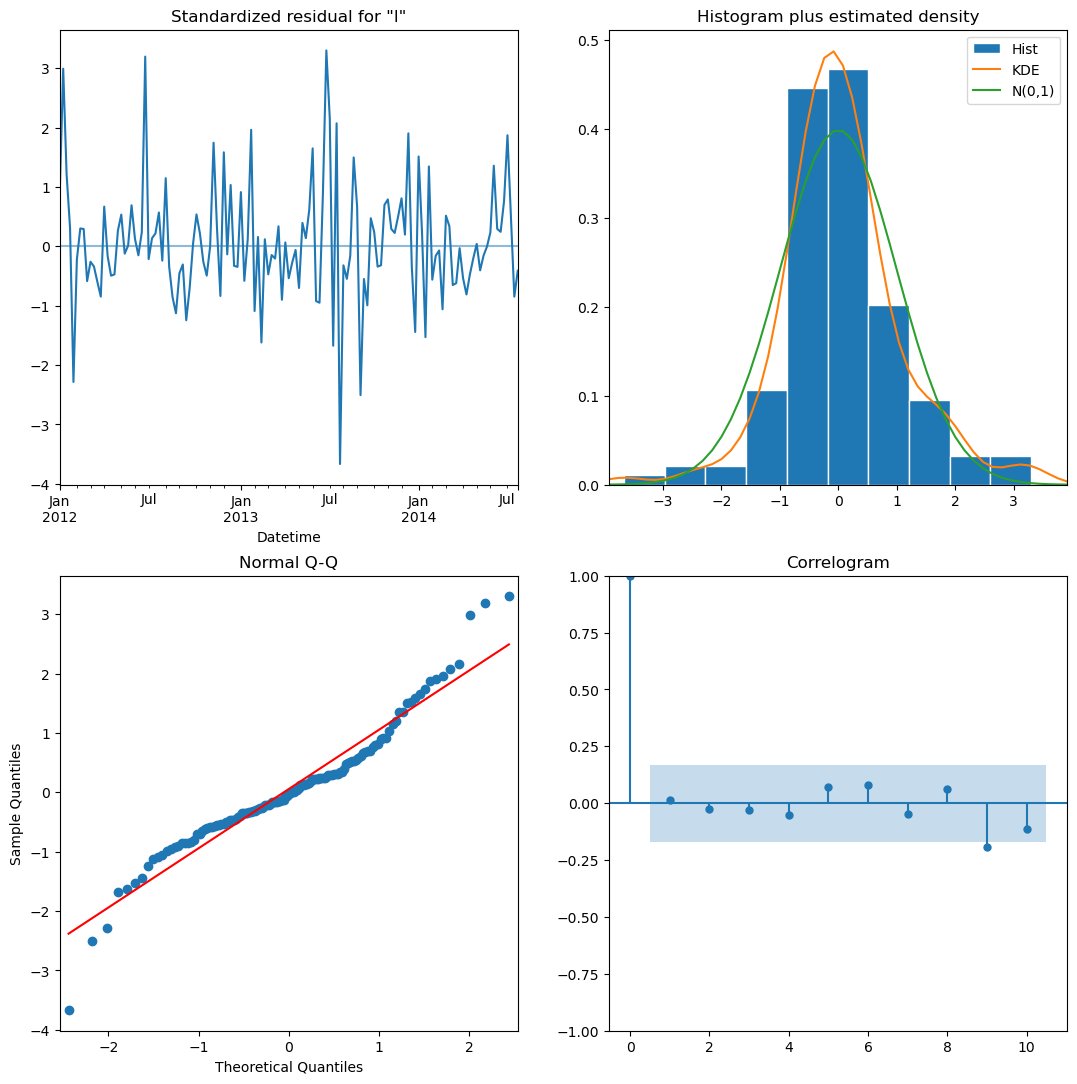

In [33]:
ARMAmodel = SARIMAX(train_load['load'], order=(3, 0, 2))
ARMAmodel_fit = ARMAmodel.fit()
print(ARMAmodel_fit.summary())

ARMAmodel_fit.plot_diagnostics(figsize=(13, 13));

### **Residual analysis**

#### "To have a good model for making forecasts, the residuals must be uncorrelated and have a normal distribution"<br>Pela observação do histograma e o QQplot é possível observar que os resíduos não estão distribuidos de maneira aproximadamente normal, os pontos do QQ plot desviam-se da linha diagonal, indicando um desvio de uma destribuição normal como podemos verificar no histograma.
#### Para testar a correlação dos resíduos podemos ainda usar o teste Ljung-Box

In [34]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#run the lJung-Box test on the residuals fot he first 10 lags

residuals = ARMAmodel_fit.resid

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))
residuals_test.index.name= 'Lags'
residuals_test

lb_stat  lb_pvalue
Lags                     
1     2.003663   0.156920
2     2.200481   0.332791
3     2.200922   0.531767
4     3.583391   0.465312
5     3.596206   0.608883
6     3.736983   0.712219
7     3.738491   0.809357
8     3.743021   0.879533
9     4.284221   0.891730
10    4.562548   0.918423

### Valores de p-value mais altos indicam que os resíduos são mais provavelmente independentes entre si, enquanto p-value mais baixos sugerem a presença de autocorrelação nos resíduos.<br>Logo, como os valores estão muito baixos, entedemos que existe autocorrelação nos resíduos e este modelo não é ideal para forescast.
## Vamos na mesma, visualizar o forescast usando este modelo para comfirmar estas deduções.

predicted=3530.233156, expected=3377.654762
predicted=3342.075250, expected=3465.327381
predicted=3426.858138, expected=3348.244048
predicted=3408.505830, expected=3282.178571
predicted=3316.001989, expected=3496.678571
predicted=3382.955957, expected=3591.476190
predicted=3546.616075, expected=3127.375000
predicted=3340.369692, expected=3043.928571
predicted=3071.225839, expected=3094.017857
predicted=2913.476316, expected=3118.678571
predicted=3024.676473, expected=3092.095238
predicted=3199.650821, expected=3119.553571
predicted=3218.837311, expected=3119.863095
predicted=3072.776018, expected=3145.035714
predicted=3038.863062, expected=3175.636905
predicted=3163.702915, expected=3254.148810
predicted=3310.221865, expected=3462.303571
predicted=3457.709215, expected=3241.934524
predicted=3269.555060, expected=3487.422619
predicted=3424.821401, expected=3498.845238
predicted=3483.676490, expected=3494.767857
predicted=3529.478742, expected=3197.470238
predicted=3282.222437, expected=

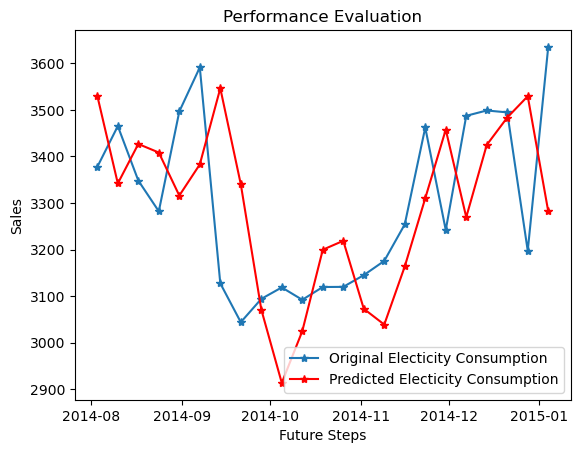

Test Root Mean Squared Error: 37113.312


In [35]:
history = [x for x in train_load['load']]
predictions = []


for t in range(len(test_load['load'])):
	model = SARIMAX(history, order=(3,0,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_load['load'][t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


# plot
plt.plot(test_load.index, test_load['load'], label = 'Original Electicity Consumption', marker = '*')
plt.plot(test_load.index, predictions, color='red', label = 'Predicted Electicity Consumption', marker = '*')
plt.title('Performance Evaluation')
plt.xlabel('Future Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
error = mean_squared_error(test_load['load'], predictions)
print('Test Root Mean Squared Error:' , round(error, 3))

## Vamos compará-lo a outros 2 metodos

In [36]:
def rolling_forecast(df, train_len, horizon, window, method):
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i])
            pred_mean.extend(mean for _ in range(window))

        return pred_mean
    
    elif method == 'last':
        pread_last_value = []

        for i in range (train_len, total_len, window):
            last_value = df[:i].iloc[-1]
            pread_last_value.extend(last_value for _ in range(window))
        return pread_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [37]:
TRAIN_LEN = len(train_load)
HORIZON = len(test_load)
WINDOW = 1

pred_mean = rolling_forecast(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test_load.loc[:, 'pred_mean'] = pred_mean
test_load.loc[:, 'pred_last_value'] = pred_last_value
test_load.loc[:, 'pred_ARMA'] = pred_ARMA
test_load.drop('T', axis=1, inplace=True)
test_load.head()

load    pred_mean  pred_last_value    pred_ARMA
Datetime                                                          
2014-08-03  3377.654762  3304.020370      3586.130952  3530.233156
2014-08-10  3465.327381  3304.561800      3377.654762  3342.075250
2014-08-17  3348.244048  3305.735271      3465.327381  3426.858138
2014-08-24  3282.178571  3306.043306      3348.244048  3408.505830
2014-08-31  3496.678571  3305.871617      3282.178571  3316.001989

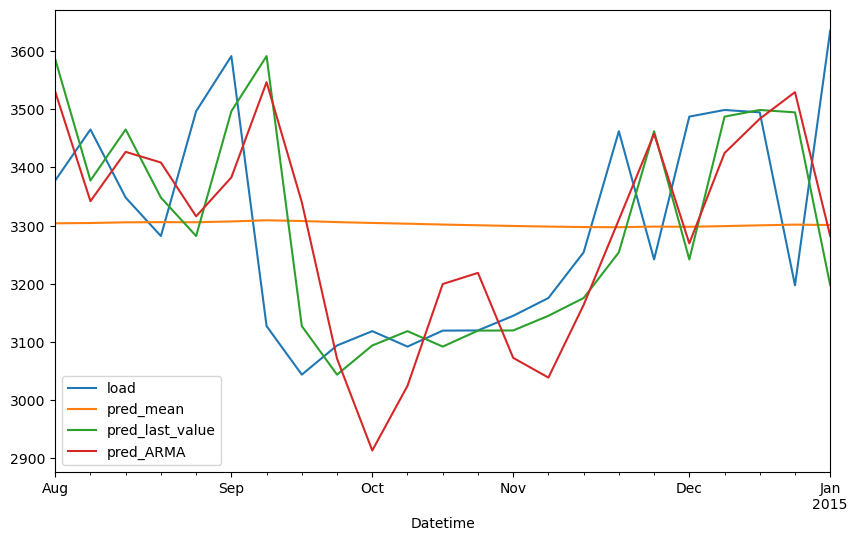

In [38]:
plt.rcParams["figure.figsize"] = (10,6)
test_load.plot()
plt.show()

## **Avaliação do modelo**

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse_mean = mean_squared_error(test_load['load'].values, test_load['pred_mean'].values)
mse_last = mean_squared_error(test_load['load'].values, test_load['pred_last_value'].values)
mse_ARMA = mean_squared_error(test_load['load'].values, test_load['pred_ARMA'].values)

print('MSE historical Mean:', round(mse_mean, 3))
print('MSE last value:', round(mse_last, 3))
print('MSE ARMA:', round(mse_ARMA, 3))

MSE historical Mean: 32655.816
MSE last value: 34407.671
MSE ARMA: 37113.312


### **Observações**
#### Como podemos verificar pelo gráfico e avaliação do erro do modelo, as nossas deduções depois da analise dos residuos estava correta. Este modelo ARMA(3,2), não é o mais adequado para a nossa sérire temporal.<br>Surpreendentemente, comparativamente ao "the last known value method" e "mean method", este útltimo foi o que teve melhores resultados na avaliação dos modelos e o ARMA obteve os piores resultados dos 3. 

# **SARIMA(p,d,q)(P,D,Q)m**

#### Pela análise do componente sazonal na decomposição da série temporal, conseguimos identificar um padrão sazonal a cada 3 meses em dados semanais. Se um trisemanatre consiste em aproximadamente 12 semanas aplicamos a diferenciação sazonal com um atraso de 12 semanas. Isto pode ajudar a tornar a série mais estacionária e adequada para modelagem com métodos como SARIMA.

Os valores de diferenciação (d) e diferenciação sazonal (D) no modelo SARIMA são determinados para tornar a série estacionária.

Se sua série temporal já é estacionária e você está lidando com sazonalidade, pode ser que não seja necessário aplicar diferenciação (d) nos dados originais, já que sua série está estacionária. No entanto, pode ser útil considerar a diferenciação sazonal (D) para capturar a sazonalidade de maneira mais eficaz.

Os valores de d e D no SARIMA indicam o número de vezes que a série temporal foi diferenciada (d) e diferenciada sazonalmente (D), respectivamente. Esses valores são determinados ao observar os gráficos de autocorrelação e autocorrelação parcial (ACF e PACF) dos dados diferenciados em busca de padrões que ainda não foram capturados.

Se a série original já é estacionária e exibe sazonalidade, você pode começar com valores de d = 0 (sem diferenciação) e avaliar se a diferenciação sazonal (D) é necessária, observando a ACF e PACF dos dados diferenciados sazonalmente para identificar padrões significativos. A presença de padrões significativos nos lags sazonais indicaria a necessidade de diferenciação sazonal (D > 0).

In [40]:
#Seasonal differencing
df_seasonal_diff = np.diff(df_semana['load'], n=12)

ADF_result = adfuller(df_seasonal_diff)
print(f'ADF Statistic:{ADF_result[0]}')
print(f'p-value:{ADF_result[1]}')

ADF Statistic:-12.7966308933401
p-value:6.89377603674501e-24


In [41]:
df_diff = pd.DataFrame({'load': df_seasonal_diff})
df_diff

load
0   -101554.273810
1     67734.184524
2    -54415.785714
3     50924.244048
4    -57437.934524
..             ...
141  -14394.172619
142  -19642.107143
143   86206.154762
144 -178379.833333
145  258320.031800

[146 rows x 1 columns]

In [42]:
from typing import Union

def optimize_SARIMA(data : Union[pd.Series, list], order_list:list, d:int, D:int, s:int)->pd.DataFrame:
    results=[]
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q, P, Q)', 'AIC']

    #Sort in ascending orde, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [43]:
from itertools import product
d=0
D=1
s=12

#values [0,1,2,3] to try for p,q,P,Q

ps = range(0,4,1)
qs = range(0,4,1)
Ps = range(0,4,1)
Qs = range(0,4,1)

#generate the unique combinations os values 
parameters_SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
SARIMA_result_df = optimize_SARIMA(train_load['load'], SARIMA_order_list, d, D, s)

In [44]:
SARIMA_result_df.sort_values(by='AIC', ascending = True).reset_index(drop=True)

(p, q, P, Q)          AIC
0    (3, 2, 0, 3)  1621.399308
1    (3, 2, 2, 1)  1621.884496
2    (1, 3, 0, 3)  1622.280865
3    (1, 3, 1, 2)  1622.422590
4    (1, 3, 0, 1)  1622.563756
..            ...          ...
248  (0, 3, 2, 3)  1740.659098
249  (0, 2, 0, 0)  1752.010525
250  (0, 0, 0, 1)  1764.218893
251  (0, 1, 0, 0)  1780.290825
252  (0, 0, 0, 0)  1864.861721

[253 rows x 2 columns]

                                         SARIMAX Results                                          
Dep. Variable:                                       load   No. Observations:                  135
Model:             SARIMAX(3, 0, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -801.700
Date:                                    Fri, 29 Dec 2023   AIC                           1621.399
Time:                                            13:49:43   BIC                           1646.709
Sample:                                        01-01-2012   HQIC                          1631.680
                                             - 07-27-2014                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9535      0.132      7.241      0

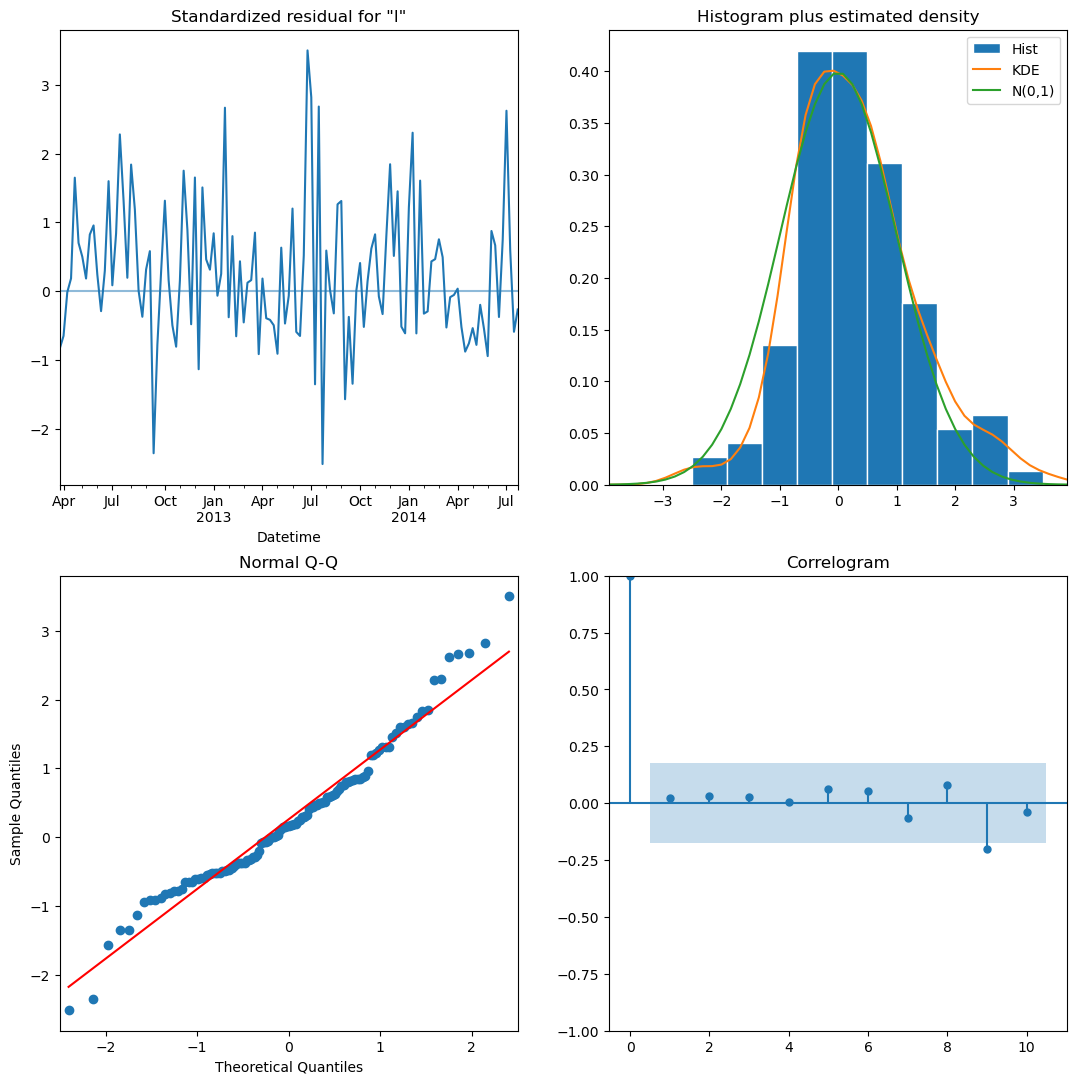

In [45]:
SARIMA_model = SARIMAX(train_load['load'],order=(3,0,2), seasonal_order=(0,1,3,12))
 
SARIMA_model_fit = SARIMA_model.fit(disp=False)
 
print(SARIMA_model_fit.summary())
 
SARIMA_model_fit.plot_diagnostics(figsize=(13,13));

### Apesar de não ser perfeito, conseguimos verificar que este modelo se adequa melhor ao nosso problema do que o ARMA(p,q), KDE está mais proximo da normal do que o modelo ARMA(3,2) e os pontos mais proximos da linha, mas longe de ser perfeito.

predicted=3469.812391, expected=3377.654762
predicted=3223.594754, expected=3465.327381
predicted=3372.141654, expected=3348.244048
predicted=3451.463373, expected=3282.178571
predicted=3353.169457, expected=3496.678571
predicted=3390.750510, expected=3591.476190
predicted=3462.225049, expected=3127.375000
predicted=3284.104674, expected=3043.928571
predicted=3107.210212, expected=3094.017857
predicted=3055.303957, expected=3118.678571
predicted=3041.601523, expected=3092.095238
predicted=3143.421866, expected=3119.553571
predicted=3171.761946, expected=3119.863095
predicted=3091.668780, expected=3145.035714
predicted=3102.510111, expected=3175.636905
predicted=3109.958923, expected=3254.148810
predicted=3361.469353, expected=3462.303571
predicted=3493.896615, expected=3241.934524
predicted=3335.465262, expected=3487.422619
predicted=3302.897845, expected=3498.845238
predicted=3395.320038, expected=3494.767857
predicted=3529.589996, expected=3197.470238
predicted=3305.156690, expected=

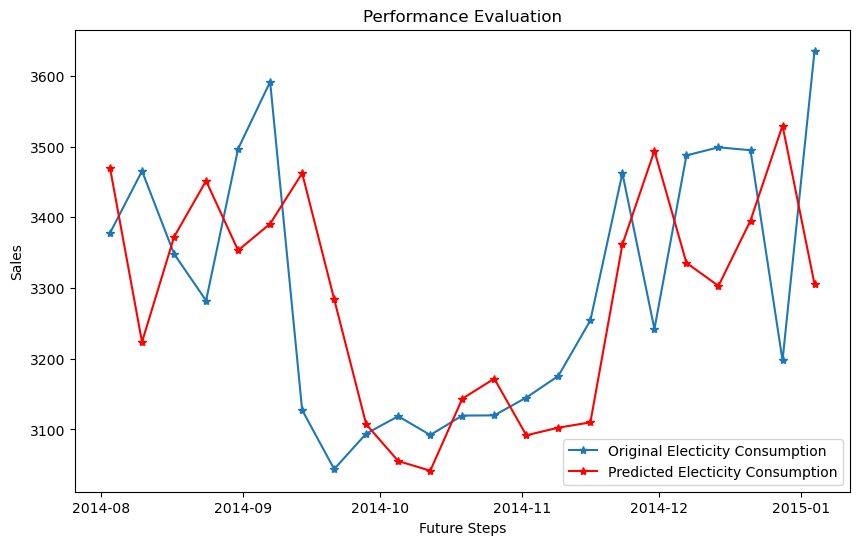

Test Root Mean Squared Error: 31749.981


In [46]:
history = [x for x in train_load['load']]
predictions = []


for t in range(len(test_load['load'])):
	model = SARIMAX(history,order=(3,0,2), seasonal_order=(0,1,3,12), simple_differencing=False)
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_load['load'][t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


# plot
plt.plot(test_load.index, test_load['load'], label = 'Original Electicity Consumption', marker = '*')
plt.plot(test_load.index, predictions, color='red', label = 'Predicted Electicity Consumption', marker = '*')
plt.title('Performance Evaluation')
plt.xlabel('Future Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
error = mean_squared_error(test_load['load'], predictions)
print('Test Root Mean Squared Error:' , round(error, 3))

In [47]:
def rolling_forecast2(df, train_len, horizon, window, method):
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i])
            pred_mean.extend(mean for _ in range(window))

        return pred_mean
    
    elif method == 'last':
        pread_last_value = []

        for i in range (train_len, total_len, window):
            last_value = df[:i].iloc[-1]
            pread_last_value.extend(last_value for _ in range(window))
        return pread_last_value
    
    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,2), seasonal_order=(0,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA
    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [48]:
TRAIN_LEN = len(train_load)
HORIZON = len(test_load)
WINDOW = 1

pred_mean = rolling_forecast2(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast2(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast2(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_ARMA = rolling_forecast2(df_semana['load'], TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test_load.loc[:, 'pred_mean'] = pred_mean
test_load.loc[:, 'pred_last_value'] = pred_last_value
test_load.loc[:, 'pred_ARMA'] = pred_ARMA
test_load.loc[:, 'pred_SARIMA'] = pred_SARIMA

test_load.head()

load    pred_mean  pred_last_value    pred_ARMA  \
Datetime                                                             
2014-08-03  3377.654762  3304.020370      3586.130952  3530.233156   
2014-08-10  3465.327381  3304.561800      3377.654762  3342.075250   
2014-08-17  3348.244048  3305.735271      3465.327381  3426.858138   
2014-08-24  3282.178571  3306.043306      3348.244048  3408.505830   
2014-08-31  3496.678571  3305.871617      3282.178571  3316.001989   

            pred_SARIMA  
Datetime                 
2014-08-03  3469.812391  
2014-08-10  3223.594754  
2014-08-17  3372.141654  
2014-08-24  3451.463373  
2014-08-31  3353.169457

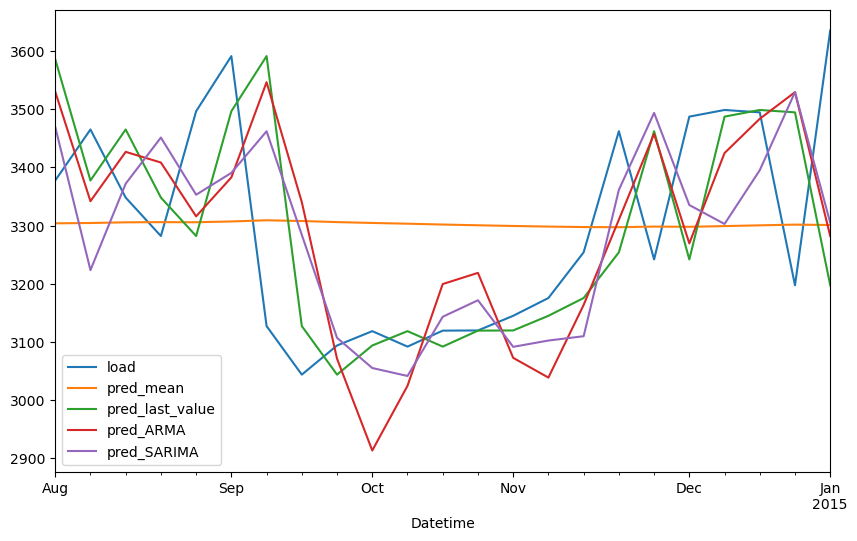

In [49]:
plt.rcParams["figure.figsize"] = (10,6)
test_load.plot()
plt.show()

## **Avaliação do modelo**

In [50]:
mse_mean = mean_squared_error(test_load['load'].values, test_load['pred_mean'].values)
mse_last = mean_squared_error(test_load['load'].values, test_load['pred_last_value'].values)
mse_ARMA = mean_squared_error(test_load['load'].values, test_load['pred_ARMA'].values)
mse_SARIMA = mean_squared_error(test_load['load'].values, test_load['pred_SARIMA'].values)

print('MSE historical Mean:', round(mse_mean, 3))
print('MSE last value:', round(mse_last, 3))
print('MSE ARMA:', round(mse_ARMA, 3))
print('MSE SARIMA:', round(mse_SARIMA, 3))

MSE historical Mean: 32655.816
MSE last value: 34407.671
MSE ARMA: 37113.312
MSE SARIMA: 31749.981


### Como podemos observar pelos gráficos e resultados obtidos MSE, podemos concluir que este modelo obteve melhores resultados que os restantes, inclusive o modelo ARMA(3,2), anteriormente utilizado. No entanto, apesar de prever melhor que o modelo ARMA(3,2), este modelo SARIMA()

# **Machine learning models**

## **Function to perform the slide windowing of a time series with n independent variables and m dependent variables.**

In [51]:
def slideWindow(df, window_in, horizon):
    d = df.values
    X, y = [], []
    idx = df.index[:-window_in]
    for start in range(len(df)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))
        y.append(d[end:out].ravel())
    cols_x = [f'x{i}' for i in range(1, window_in+1)]
    cols_y = [f'y{i}' for i in range(1, horizon+1)]
    df_xs = pd.DataFrame(X, index=idx, columns=cols_x)
    df_y = pd.DataFrame(y, index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

## **Transform your time series to contain n=6 independent and m=1 dependent variable using the previous function.**

In [52]:
win_in = 6 # the number of lag variable
HORIZON = 1 # predict one step ahead: next week consuption

train_shift = slideWindow(train_load['load'], win_in, HORIZON)
test_shift = slideWindow(test_load['load'], win_in, HORIZON)

x_train = train_shift.iloc[:, :-1] # all columns except last
y_train = train_shift.iloc[:, -1:] # last column

x_test = test_shift.iloc[:, :-1]
y_test = test_shift.iloc[:, -1:]

In [53]:
train_shift.head(7)

x1           x2           x3           x4           x5  \
Datetime                                                                      
2012-01-01  2991.458333  3481.565476  3550.791667  3605.345238  3332.321429   
2012-01-08  3481.565476  3550.791667  3605.345238  3332.321429  3391.470238   
2012-01-15  3550.791667  3605.345238  3332.321429  3391.470238  3327.130952   
2012-01-22  3605.345238  3332.321429  3391.470238  3327.130952  3288.196429   
2012-01-29  3332.321429  3391.470238  3327.130952  3288.196429  3250.547619   
2012-02-05  3391.470238  3327.130952  3288.196429  3250.547619  3289.184524   
2012-02-12  3327.130952  3288.196429  3250.547619  3289.184524  3195.404762   

                     x6           y1  
Datetime                              
2012-01-01  3391.470238  3327.130952  
2012-01-08  3327.130952  3288.196429  
2012-01-15  3288.196429  3250.547619  
2012-01-22  3250.547619  3289.184524  
2012-01-29  3289.184524  3195.404762  
2012-02-05  3195.404762  3055.500000  
2012-02-12  3055.500000  2953.458333

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

algs = [
    ('lr', LinearRegression()),
    ('ridge', Ridge(random_state=42)),
    ('lasso', Lasso(random_state=42)),
    ('elastic_net', ElasticNet(random_state=42)),
    ('dtr', DecisionTreeRegressor(random_state=42)),
    ('rndf', RandomForestRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('svr', SVR(kernel='poly', degree=2)),
    ('knr', KNeighborsRegressor()),
    ('mlp', MLPRegressor(random_state=42))
]

listScores=[]
for name, alg in algs:
    model = alg.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print("%s: %f %f %f" % (name, mae, mse, mape))

    res = pd.Series({'Model': name+ '-os', 'mae' : mae, 'mse': mse, 'mape': mape})
    listScores.append(res)

lr: 130.376773 32670.545351 0.039902
ridge: 130.376764 32670.538747 0.039902
lasso: 130.371843 32669.121497 0.039901
elastic_net: 130.373794 32669.400297 0.039902
dtr: 230.142977 83138.928277 0.070632
rndf: 155.525071 41269.430754 0.047100
gbr: 154.340186 39398.979744 0.046719
svr: 130.843292 32265.439032 0.039886
knr: 126.242487 28020.402133 0.038411
mlp: 426.180694 223090.844290 0.134001


In [55]:
df_models = pd.DataFrame(listScores)
df_models.sort_values(by=['mse'], inplace=True)
df_models

Model         mae            mse      mape
8          knr-os  126.242487   28020.402133  0.038411
7          svr-os  130.843292   32265.439032  0.039886
2        lasso-os  130.371843   32669.121497  0.039901
3  elastic_net-os  130.373794   32669.400297  0.039902
1        ridge-os  130.376764   32670.538747  0.039902
0           lr-os  130.376773   32670.545351  0.039902
6          gbr-os  154.340186   39398.979744  0.046719
5         rndf-os  155.525071   41269.430754  0.047100
4          dtr-os  230.142977   83138.928277  0.070632
9          mlp-os  426.180694  223090.844290  0.134001

## **Single-step model**
### Predicts one step into the future for one variable<br>Vamos utilizar o modelo que obteve melhores resultados (KNeighborsRegressor)


In [56]:
alg = KNeighborsRegressor()
kn = alg.fit(x_train, y_train)
y_pred = kn.predict(x_test)

#criar dataframe com as previsões
idx = y_test.index
df_pred = pd.DataFrame(y_pred, columns=['y_pred'], index=idx)

single_df = pd.concat([y_test, df_pred], axis=1)
single_df.rename({'y1': 'y_test'}, axis='columns', inplace=True)
single_df.head()

y_test       y_pred
Datetime                            
2014-08-03  3127.375000  3366.140476
2014-08-10  3043.928571  3229.283333
2014-08-17  3094.017857  3043.695238
2014-08-24  3118.678571  3034.690476
2014-08-31  3092.095238  3024.202381

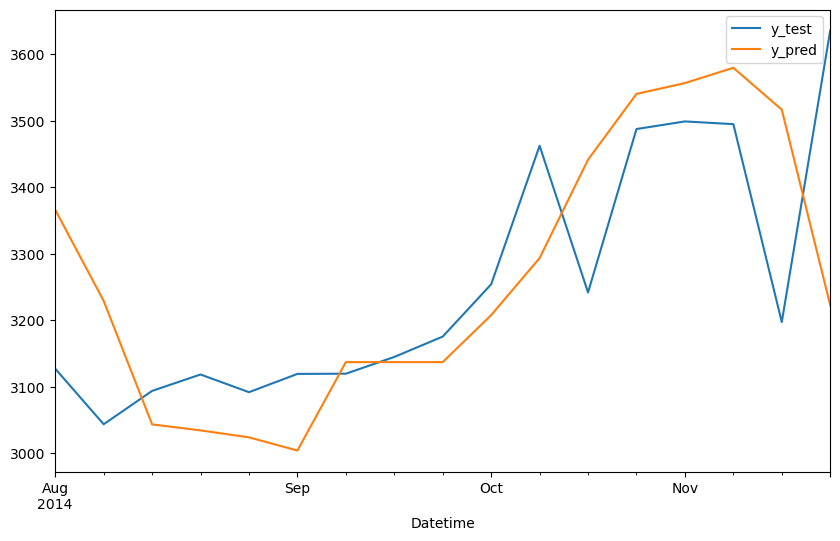

In [57]:
single_df.plot()
plt.show()

## **Multi-step model**
### Predicts many steps into the future

In [58]:
win_in = 6 # the number of lag variable
HORIZON = 3 # predict one step ahead: next 4 weeks electricity consumption

train_shift = slideWindow(train_load['load'], win_in, HORIZON)
test_shift = slideWindow(test_load['load'], win_in, HORIZON)

x_train = train_shift.iloc[:, :-HORIZON] # all columns except last
y_train = train_shift.iloc[:, -HORIZON:] # last column

x_test = test_shift.iloc[:, :-HORIZON]
y_test = test_shift.iloc[:, -HORIZON:]

print('x_train', x_train.shape, 'y_train', y_train.shape, 'x_test', x_test.shape, 'y_test', y_test.shape)
train_shift.head()

x_train (127, 6) y_train (127, 3) x_test (15, 6) y_test (15, 3)


x1           x2           x3           x4           x5  \
Datetime                                                                      
2012-01-01  2991.458333  3481.565476  3550.791667  3605.345238  3332.321429   
2012-01-08  3481.565476  3550.791667  3605.345238  3332.321429  3391.470238   
2012-01-15  3550.791667  3605.345238  3332.321429  3391.470238  3327.130952   
2012-01-22  3605.345238  3332.321429  3391.470238  3327.130952  3288.196429   
2012-01-29  3332.321429  3391.470238  3327.130952  3288.196429  3250.547619   

                     x6           y1           y2           y3  
Datetime                                                        
2012-01-01  3391.470238  3327.130952  3288.196429  3250.547619  
2012-01-08  3327.130952  3288.196429  3250.547619  3289.184524  
2012-01-15  3288.196429  3250.547619  3289.184524  3195.404762  
2012-01-22  3250.547619  3289.184524  3195.404762  3055.500000  
2012-01-29  3289.184524  3195.404762  3055.500000  2953.458333

In [59]:
alg = KNeighborsRegressor()
kn = alg.fit(x_train, y_train)
y_pred = kn.predict(x_test)

#criar dataframe com as previsões
df_pred = pd.DataFrame()
df_pred.index = y_test.index
df_pred [['y_pred1', 'y_pred2', 'y_pred3']] = y_pred
df_pred.rename({'y_test': 'y1'}, axis='columns', inplace=True)

multi_df = pd.concat([y_test, df_pred], axis=1)
multi_df.rename({'y_test':'y1'}, axis='columns', inplace=True)
multi_df.head()

y1           y2           y3      y_pred1      y_pred2  \
Datetime                                                                      
2014-08-03  3127.375000  3043.928571  3094.017857  3366.140476  3457.394048   
2014-08-10  3043.928571  3094.017857  3118.678571  3229.283333  3210.269048   
2014-08-17  3094.017857  3118.678571  3092.095238  3043.695238  3043.402381   
2014-08-24  3118.678571  3092.095238  3119.553571  3034.690476  3017.979762   
2014-08-31  3092.095238  3119.553571  3119.863095  3024.202381  3015.754762   

                y_pred3  
Datetime                 
2014-08-03  3366.417857  
2014-08-10  3127.377381  
2014-08-17  3004.013095  
2014-08-24  2983.820238  
2014-08-31  3003.698810

In [60]:
def plot_semanal_pred(preds_df, horizon, desc):
    fig, ax = plt.subplots(horizon, 1, figsize=(5*horizon, 12))
    plt.subplots_adjust(hspace=0.5) # padding entre os subplots
    for i in range(horizon):
        preds_df.iloc[:, [i, i+horizon]].plot(title=desc+ ' ' + str(i+1), ax=ax[i])
    plt.show()

In [61]:
def avaliar_modelo(modelo, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results = pd.Series({'Model': modelo, 'mae': mae, 'mse': mse, 'mape': mape})
    return results

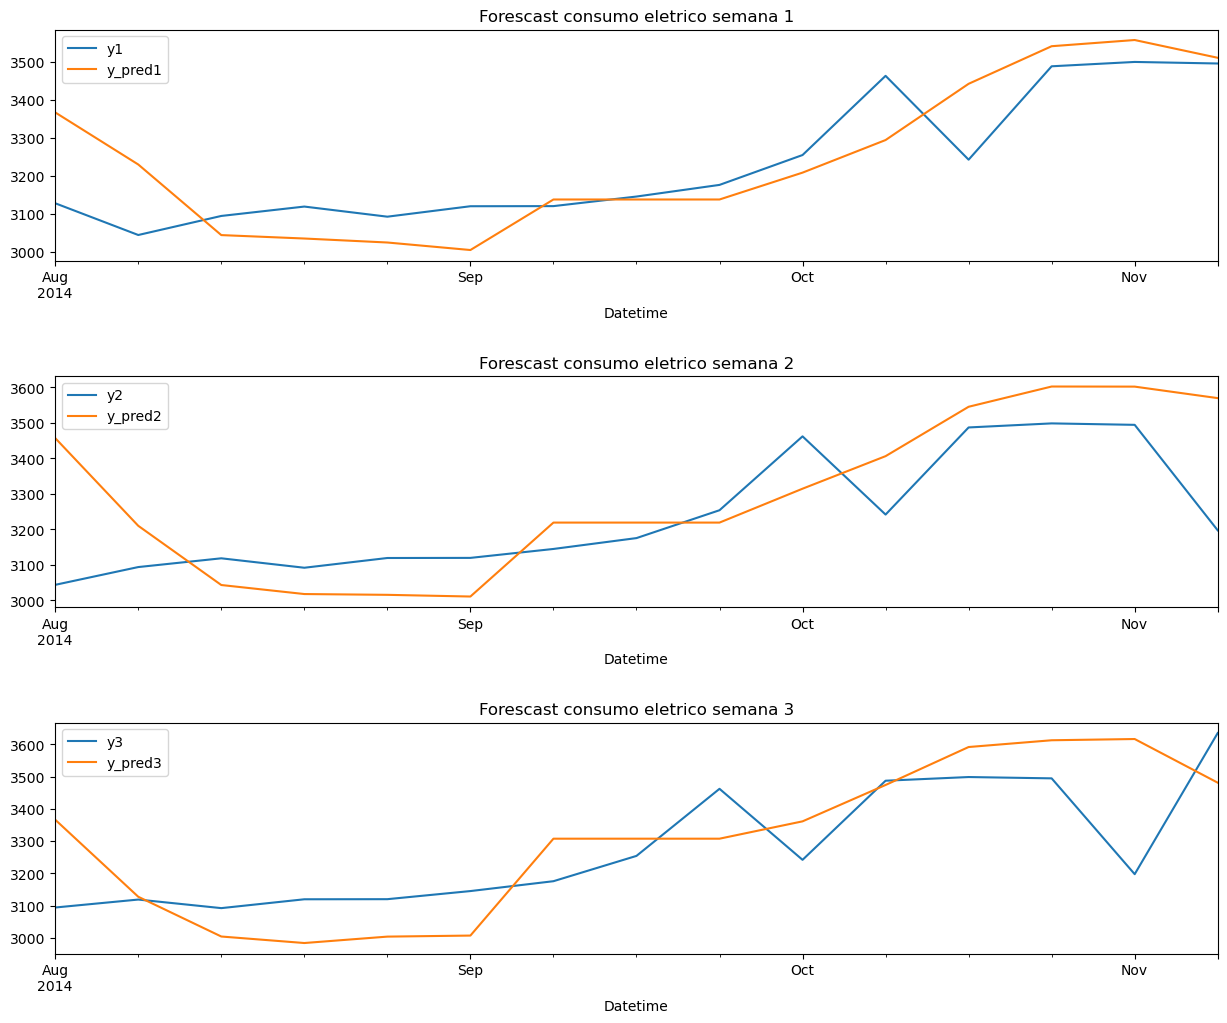

In [62]:
plot_semanal_pred(multi_df, HORIZON, "Forescast consumo eletrico semana")

In [63]:
res = []
result = avaliar_modelo('Single Step-model', single_df['y_test'], single_df['y_pred'])
res.append(result)

result = avaliar_modelo('Multi Step-model', multi_df.iloc[:,[0,1,2]], multi_df.iloc[:,[3,4,5]])
res.append(result)

resdf = pd.DataFrame(res)
resdf

Model         mae           mse      mape
0  Single Step-model  126.242487  28020.402133  0.038411
1   Multi Step-model  119.123881  23369.225298  0.037020

### Surpreendentemente,o forecast para 3 semanas do consumo de eltricidade tem menos erro que o forescast de apenas 1 semana.

# **Deep learning models**

## **Split the data in train, validation and test sets.**

In [186]:
# Define the sizes for train, validation, and test sets
train_size = int(len(df_semana) * 0.7)  # 70% for training
val_size = int(len(df_semana) * 0.15)   # 15% for validation
test_size = len(df_semana) - train_size - val_size  # Remaining 15% for testing

# Split the data
train_data = df_semana.iloc[:train_size]
val_data = df_semana.iloc[train_size:train_size + val_size]
test_data = df_semana.iloc[train_size + val_size:]

# Check the lengths of each set
print(f"Train: {len(train_data)}\nValidation: {len(val_data)}\nTest: {len(test_data)}\n")

Train: 110
Validation: 23
Test: 25



## **Normalizar os dados**

In [187]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data['load'] = scaler.fit_transform(train_data)
val_data['load'] = scaler.transform(val_data)
test_data['load'] = scaler.transform(test_data)

In [218]:
win_in = 6 # the number of lag variable
HORIZON = 1 # predict one step ahead: next say temperature

train_shift = slideWindow(train_data['load'], win_in, HORIZON)
valid_shift = slideWindow(val_data['load'], win_in, HORIZON)
test_shift = slideWindow(test_data['load'], win_in, HORIZON)

train_shift.head()

x1        x2        x3        x4        x5        x6  \
Datetime                                                                 
2012-01-01  0.073754  0.455569  0.509499  0.551999  0.339301  0.385381   
2012-01-08  0.455569  0.509499  0.551999  0.339301  0.385381  0.335258   
2012-01-15  0.509499  0.551999  0.339301  0.385381  0.335258  0.304926   
2012-01-22  0.551999  0.339301  0.385381  0.335258  0.304926  0.275596   
2012-01-29  0.339301  0.385381  0.335258  0.304926  0.275596  0.305696   

                  y1  
Datetime              
2012-01-01  0.335258  
2012-01-08  0.304926  
2012-01-15  0.275596  
2012-01-22  0.305696  
2012-01-29  0.232637

In [189]:
test_shift.head()

x1        x2        x3        x4        x5        x6  \
Datetime                                                                 
2014-07-20  0.518454  0.537030  0.374618  0.442919  0.351706  0.300238   
2014-07-27  0.537030  0.374618  0.442919  0.351706  0.300238  0.467343   
2014-08-03  0.374618  0.442919  0.351706  0.300238  0.467343  0.541194   
2014-08-10  0.442919  0.351706  0.300238  0.467343  0.541194  0.179639   
2014-08-17  0.351706  0.300238  0.467343  0.541194  0.179639  0.114631   

                  y1  
Datetime              
2014-07-20  0.467343  
2014-07-27  0.541194  
2014-08-03  0.179639  
2014-08-10  0.114631  
2014-08-17  0.153652

## **Convert train/valid/test sets to tensors**

In [219]:
y_train = train_shift['y1'].to_numpy()
print(y_train.shape)

X_train = train_shift.iloc[:,:-1].to_numpy()
X_train = X_train.reshape(X_train.shape[0], win_in, 1)
print(X_train.shape)

y_valid = valid_shift['y1'].to_numpy()
print(y_valid.shape)

X_valid = valid_shift.iloc[:,:-1].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], win_in, 1)
print(X_valid.shape)

y_test = test_shift['y1'].to_numpy()
print(y_test.shape)

X_test = test_shift.iloc[:,:-1].to_numpy()
X_test = X_test.reshape(X_test.shape[0], win_in, 1)
print(X_test.shape)


(104,)
(104, 6, 1)
(17,)
(17, 6, 1)
(19,)
(19, 6, 1)


## **One-step forecasting using a GRU model and a LSTM model to predict the next week electricity consumption.**

### **GRU Model**

In [220]:
HORIZON = 1
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5

In [221]:
gru_model = Sequential()
gru_model.add(GRU(LATENT_DIM, input_shape=(win_in, 1)))
gru_model.add(Dense(HORIZON))

gru_model.compile(optimizer='RMSprop', loss='mse')
gru_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 5)                 120       
                                                                 
 dense_15 (Dense)            (None, 1)                 6         
                                                                 
Total params: 126 (504.00 Byte)
Trainable params: 126 (504.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [222]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history=gru_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, y_valid), callbacks=[earlystop], verbose=1)

Epoch 1/50


4/4 [==============================] - 2s 102ms/step - loss: 0.0852 - val_loss: 0.0391
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0676 - val_loss: 0.0321
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0572 - val_loss: 0.0270
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0492 - val_loss: 0.0232
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0427 - val_loss: 0.0212
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0385 - val_loss: 0.0191
Epoch 7/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0340 - val_loss: 0.0182
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0313 - val_loss: 0.0177
Epoch 9/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0293 - val_loss: 0.0175
Epoch 10/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0275 - val_loss: 0.0177
Epoch 11/50
4/4 [=========================

In [223]:
gru_ts_pred = gru_model.predict(X_test)
results = test_shift[['y1']].copy()

results['GRU_pred'] = gru_ts_pred

print(results.shape)
results.head()

1/1 [==============================] - 0s 241ms/step
(19, 2)


y1  GRU_pred
Datetime                      
2014-07-20  0.467343  0.323245
2014-07-27  0.541194  0.352104
2014-08-03  0.179639  0.381543
2014-08-10  0.114631  0.312080
2014-08-17  0.153652  0.265867

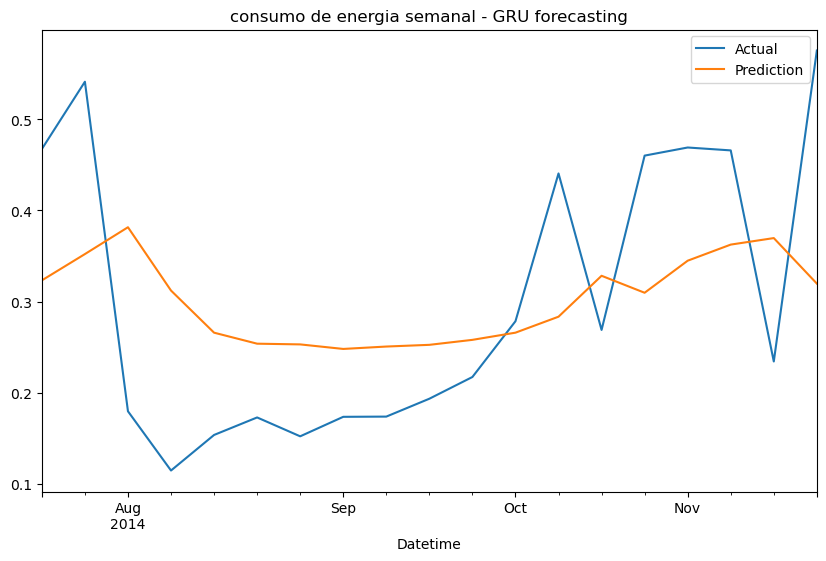

In [224]:
results.plot()
plt.title('consumo de energia semanal - GRU forecasting')
plt.legend(['Actual', 'Prediction'])
plt.show()

### **LSTM Model**

In [225]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(LATENT_DIM, input_shape=(6, 1)))
LSTM_model.add(Dense(HORIZON))

LSTM_model.compile(optimizer='RMSprop', loss='mse')
LSTM_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5)                 140       
                                                                 
 dense_16 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [226]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history=LSTM_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, y_valid), callbacks=[earlystop], verbose=1)

Epoch 1/50


4/4 [==============================] - 2s 124ms/step - loss: 0.0696 - val_loss: 0.0357
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0582 - val_loss: 0.0307
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0507 - val_loss: 0.0274
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0451 - val_loss: 0.0248
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0404 - val_loss: 0.0229
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0366 - val_loss: 0.0216
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0333 - val_loss: 0.0207
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0204
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0287 - val_loss: 0.0204
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0277 - val_loss: 0.0205
Epoch 11/50
4/4 [========================

In [227]:
lstm_ts_pred = LSTM_model.predict(X_test)
# results = test_shift[['y1']].copy()

results['LSTM_pred'] = lstm_ts_pred

print(results.shape)
results.head()

1/1 [==============================] - 0s 293ms/step
(19, 3)


y1  GRU_pred  LSTM_pred
Datetime                                 
2014-07-20  0.467343  0.323245   0.351696
2014-07-27  0.541194  0.352104   0.358599
2014-08-03  0.179639  0.381543   0.375819
2014-08-10  0.114631  0.312080   0.343063
2014-08-17  0.153652  0.265867   0.302059

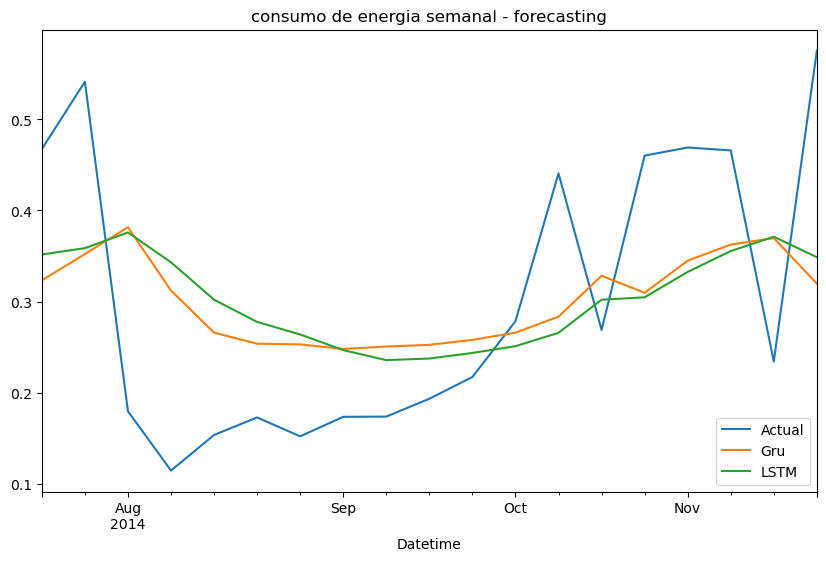

In [228]:
results.plot()
plt.title('consumo de energia semanal - forecasting')
plt.legend(['Actual', 'Gru', 'LSTM'])
plt.show()

### **Comparação dos modelos**

In [229]:
def evaluate_models(true_values, model_predictions, model_names):
    results_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'MAPE'])
    
    for i, predictions in enumerate(model_predictions):
        model_name = model_names[i]
        
        mse = mean_squared_error(true_values, predictions)
        mae = mean_absolute_error(true_values, predictions)
        mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
        
        results_df = results_df.append({'Model': model_name,
                                        'MSE': mse,
                                        'MAE': mae,
                                        'MAPE': mape}, ignore_index=True)
    
    return results_df
    
model_names = ['LSTM', 'GRU']
model_predictions = [lstm_ts_pred, gru_ts_pred]

results_df = evaluate_models(y_test, model_predictions, model_names)
results_df


Model       MSE       MAE       MAPE
0  LSTM  0.018541  0.120781  56.784576
1   GRU  0.018055  0.119788  56.191442

## **Multi-Step Forescasting**

In [230]:
Win_in = 6
HORIZON = 3 # Prever 3 semanas

train_shift = slideWindow(train_data['load'], win_in, HORIZON)
valid_shift = slideWindow(val_data['load'], win_in, HORIZON)
test_shift = slideWindow(test_data['load'], win_in, HORIZON)
 
train_shift.head()

x1        x2        x3        x4        x5        x6  \
Datetime                                                                 
2012-01-01  0.073754  0.455569  0.509499  0.551999  0.339301  0.385381   
2012-01-08  0.455569  0.509499  0.551999  0.339301  0.385381  0.335258   
2012-01-15  0.509499  0.551999  0.339301  0.385381  0.335258  0.304926   
2012-01-22  0.551999  0.339301  0.385381  0.335258  0.304926  0.275596   
2012-01-29  0.339301  0.385381  0.335258  0.304926  0.275596  0.305696   

                  y1        y2        y3  
Datetime                                  
2012-01-01  0.335258  0.304926  0.275596  
2012-01-08  0.304926  0.275596  0.305696  
2012-01-15  0.275596  0.305696  0.232637  
2012-01-22  0.305696  0.232637  0.123645  
2012-01-29  0.232637  0.123645  0.044150

In [231]:
y_train = train_shift[['y1', 'y2', 'y3']].to_numpy()
print(y_train.shape)

X_train = train_shift.iloc[:,:-3].to_numpy()
X_train = X_train.reshape(X_train.shape[0], win_in, 1)
print(X_train.shape)

y_valid = valid_shift[['y1', 'y2', 'y3']].to_numpy()
print(y_valid.shape)

X_valid = valid_shift.iloc[:,:-3].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], win_in, 1)
print(X_valid.shape)

y_test = test_shift[['y1', 'y2', 'y3']].to_numpy()
print(y_test.shape)

X_test = test_shift.iloc[:,:-3].to_numpy()
X_test = X_test.reshape(X_test.shape[0], win_in, 1)
print(X_test.shape)


(102, 3)
(102, 6, 1)
(15, 3)
(15, 6, 1)
(17, 3)
(17, 6, 1)


### **GRU Model**

In [232]:
HORIZON = 3
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 150
PATIENCE = 5

In [233]:
gru_model = Sequential()
gru_model.add(GRU(LATENT_DIM, input_shape=(win_in, 1)))
gru_model.add(Dense(HORIZON))

gru_model.compile(optimizer='RMSprop', loss='mse')
gru_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 5)                 120       
                                                                 
 dense_17 (Dense)            (None, 3)                 18        
                                                                 
Total params: 138 (552.00 Byte)
Trainable params: 138 (552.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [234]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history=gru_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, y_valid), callbacks=[earlystop], verbose=1)

Epoch 1/150


4/4 [==============================] - 2s 100ms/step - loss: 0.1087 - val_loss: 0.0441
Epoch 2/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0968 - val_loss: 0.0393
Epoch 3/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0878 - val_loss: 0.0360
Epoch 4/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0810 - val_loss: 0.0332
Epoch 5/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0750 - val_loss: 0.0307
Epoch 6/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0694 - val_loss: 0.0289
Epoch 7/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0646 - val_loss: 0.0269
Epoch 8/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0588 - val_loss: 0.0257
Epoch 9/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0541 - val_loss: 0.0247
Epoch 10/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0505 - val_loss: 0.0240
Epoch 11/150
4/4 [===================

In [235]:
gru_ts_pred = gru_model.predict(X_test)
results = test_shift[['y1', 'y2', 'y3']].copy()

results[['GRU_pred1', 'GRU_pred2', 'GRU_pred3']] = gru_ts_pred

print(results.shape)
results.head()

1/1 [==============================] - 0s 250ms/step
(17, 6)


y1        y2        y3  GRU_pred1  GRU_pred2  GRU_pred3
Datetime                                                                 
2014-07-20  0.467343  0.541194  0.179639   0.253930   0.305367   0.338669
2014-07-27  0.541194  0.179639  0.114631   0.252739   0.316818   0.364151
2014-08-03  0.179639  0.114631  0.153652   0.255681   0.332447   0.396328
2014-08-10  0.114631  0.153652  0.172864   0.252785   0.298816   0.327195
2014-08-17  0.153652  0.172864  0.152155   0.243502   0.270329   0.270381

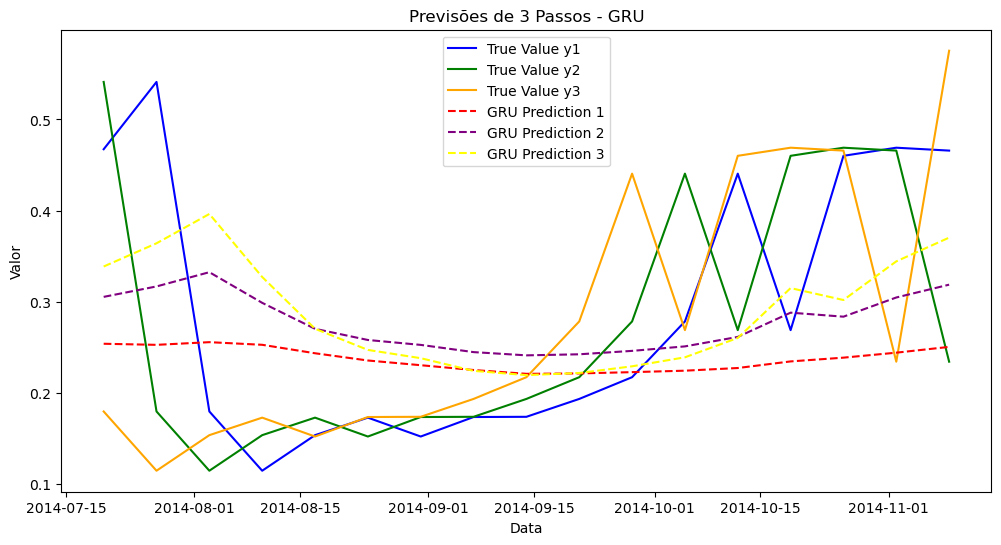

In [236]:
plt.figure(figsize=(12, 6))

# Índices para usar no gráfico
indices = results.index

# Plot dos valores verdadeiros para as 3 semanas
plt.plot(indices, results['y1'], label='True Value y1', color='blue')
plt.plot(indices, results['y2'], label='True Value y2', color='green')
plt.plot(indices, results['y3'], label='True Value y3', color='orange')

# Plot das previsões
plt.plot(indices, results['GRU_pred1'], label='GRU Prediction 1', linestyle='--', color='red')
plt.plot(indices, results['GRU_pred2'], label='GRU Prediction 2', linestyle='--', color='purple')
plt.plot(indices, results['GRU_pred3'], label='GRU Prediction 3', linestyle='--', color='yellow')

plt.title('Previsões de 3 Passos - GRU')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

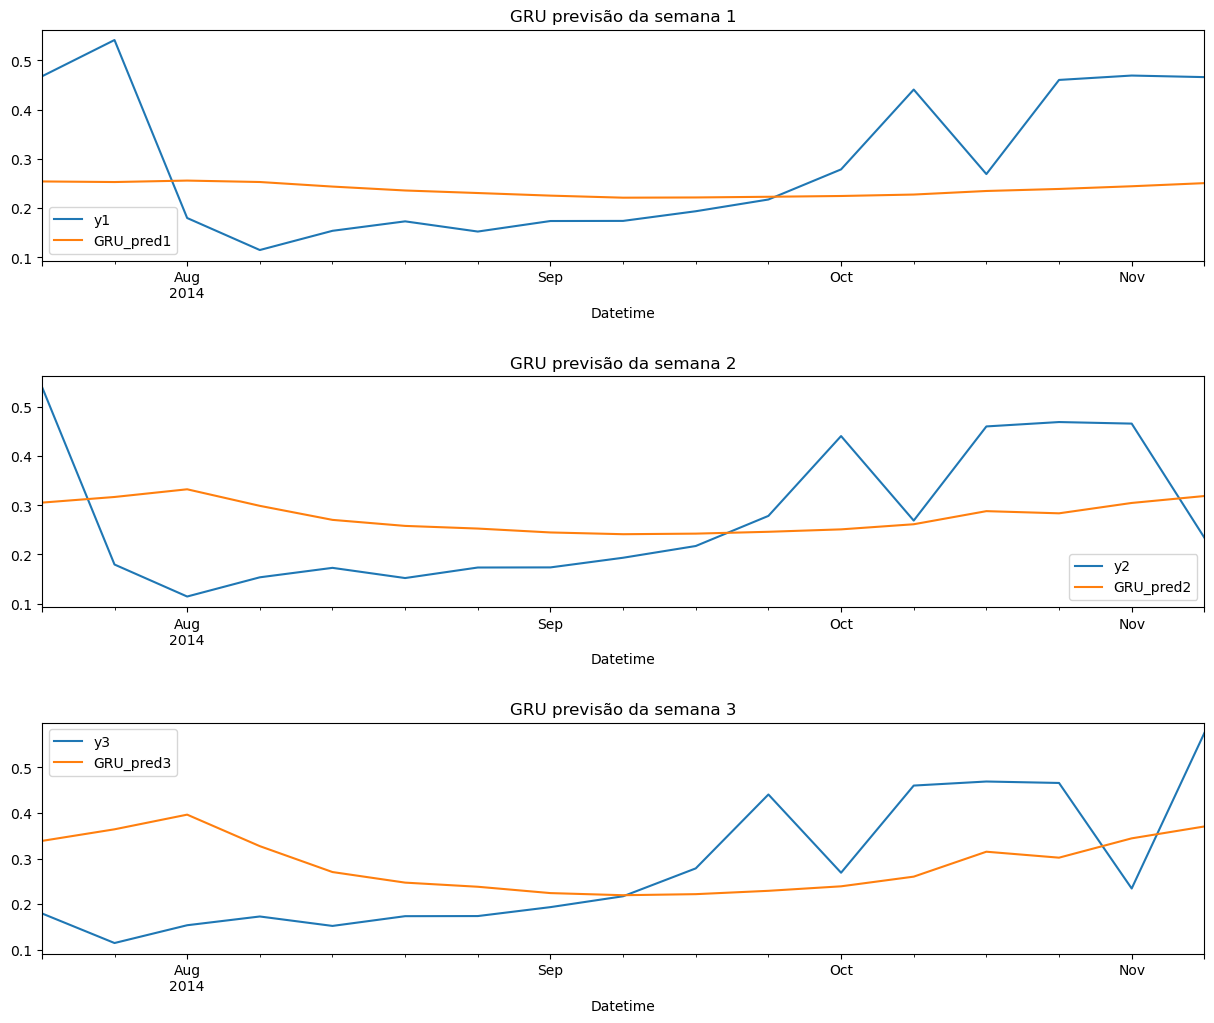

In [237]:
plot_semanal_pred(results, 3, 'GRU previsão da semana')

### **LSTM Model**

In [238]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(LATENT_DIM, input_shape=(win_in, 1)))
LSTM_model.add(Dense(HORIZON))

LSTM_model.compile(optimizer='RMSprop', loss='mse')
LSTM_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5)                 140       
                                                                 
 dense_18 (Dense)            (None, 3)                 18        
                                                                 
Total params: 158 (632.00 Byte)
Trainable params: 158 (632.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [239]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history=LSTM_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, y_valid), callbacks=[earlystop], verbose=1)

Epoch 1/150


4/4 [==============================] - 2s 109ms/step - loss: 0.0838 - val_loss: 0.0367
Epoch 2/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0761 - val_loss: 0.0342
Epoch 3/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0704 - val_loss: 0.0321
Epoch 4/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0654 - val_loss: 0.0307
Epoch 5/150
4/4 [==============================] - 0s 7ms/step - loss: 0.0615 - val_loss: 0.0298
Epoch 6/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0587 - val_loss: 0.0288
Epoch 7/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0557 - val_loss: 0.0281
Epoch 8/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0535 - val_loss: 0.0276
Epoch 9/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0507 - val_loss: 0.0271
Epoch 10/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 0.0268
Epoch 11/150
4/4 [===================

In [240]:
lstm_ts_pred = LSTM_model.predict(X_test)
# results = test_shift[['y1']].copy()

results[['LSTM_pred1', 'LSTM_pred2', 'LSTM_pred3']] = lstm_ts_pred

print(results.shape)
results.head()

1/1 [==============================] - 0s 265ms/step
(17, 9)


y1        y2        y3  GRU_pred1  GRU_pred2  GRU_pred3  \
Datetime                                                                    
2014-07-20  0.467343  0.541194  0.179639   0.253930   0.305367   0.338669   
2014-07-27  0.541194  0.179639  0.114631   0.252739   0.316818   0.364151   
2014-08-03  0.179639  0.114631  0.153652   0.255681   0.332447   0.396328   
2014-08-10  0.114631  0.153652  0.172864   0.252785   0.298816   0.327195   
2014-08-17  0.153652  0.172864  0.152155   0.243502   0.270329   0.270381   

            LSTM_pred1  LSTM_pred2  LSTM_pred3  
Datetime                                        
2014-07-20    0.215258    0.381044    0.323819  
2014-07-27    0.217685    0.400690    0.335185  
2014-08-03    0.221972    0.426058    0.348556  
2014-08-10    0.207335    0.359151    0.306510  
2014-08-17    0.191804    0.301051    0.271940

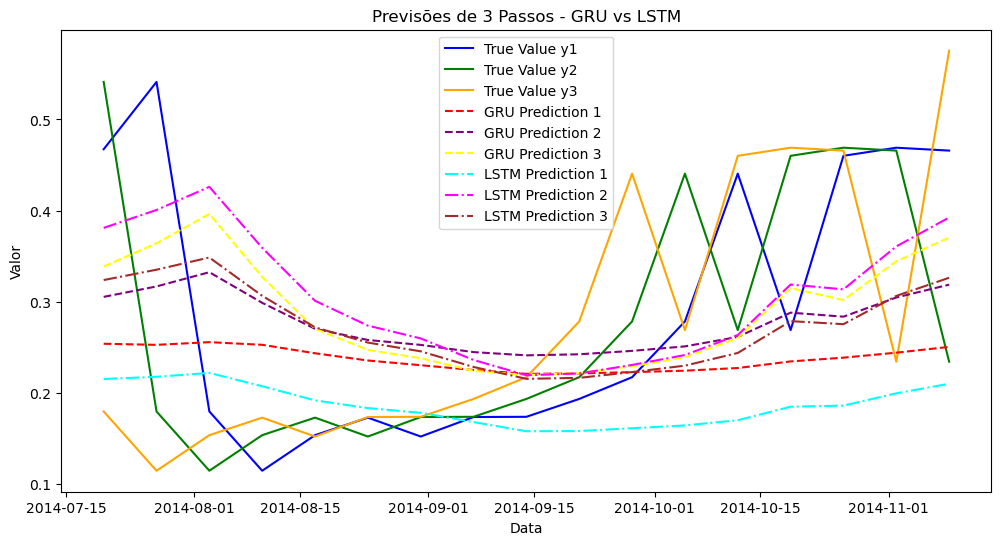

In [241]:
plt.figure(figsize=(12, 6))

# Índices para usar no gráfico
indices = results.index

# Plot dos valores verdadeiros para os três passos
plt.plot(indices, results['y1'], label='True Value y1', color='blue')
plt.plot(indices, results['y2'], label='True Value y2', color='green')
plt.plot(indices, results['y3'], label='True Value y3', color='orange')

# Plot das previsões GRU para os três passos
plt.plot(indices, results['GRU_pred1'], label='GRU Prediction 1', linestyle='--', color='red')
plt.plot(indices, results['GRU_pred2'], label='GRU Prediction 2', linestyle='--', color='purple')
plt.plot(indices, results['GRU_pred3'], label='GRU Prediction 3', linestyle='--', color='yellow')

# Plot das previsões LSTM para os três passos
plt.plot(indices, results['LSTM_pred1'], label='LSTM Prediction 1', linestyle='-.', color='cyan')
plt.plot(indices, results['LSTM_pred2'], label='LSTM Prediction 2', linestyle='-.', color='magenta')
plt.plot(indices, results['LSTM_pred3'], label='LSTM Prediction 3', linestyle='-.', color='brown')

plt.title('Previsões de 3 Passos - GRU vs LSTM')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

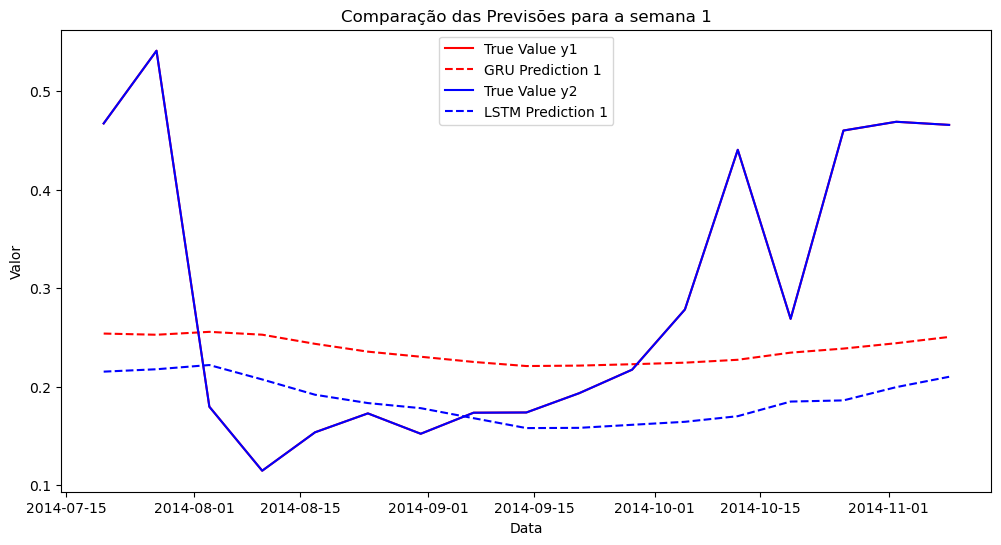

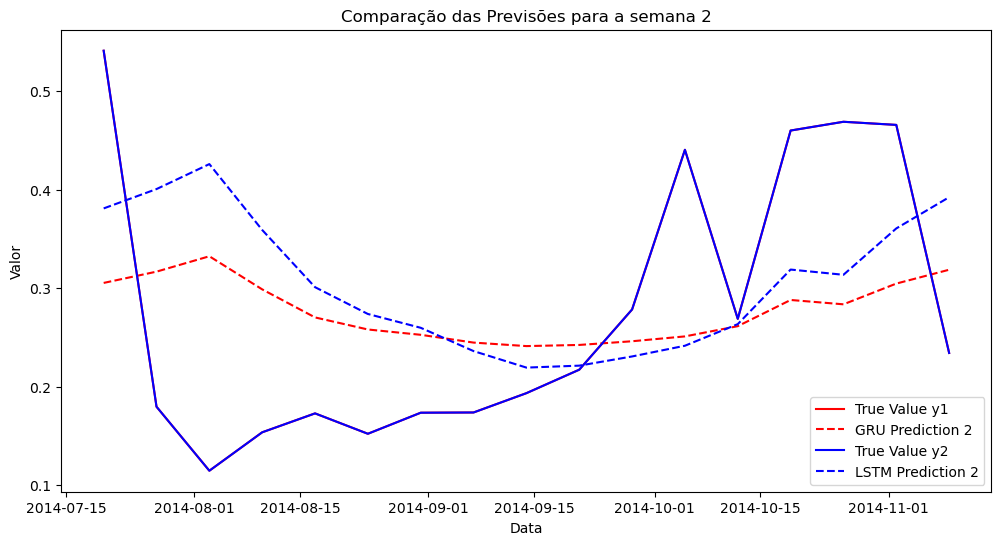

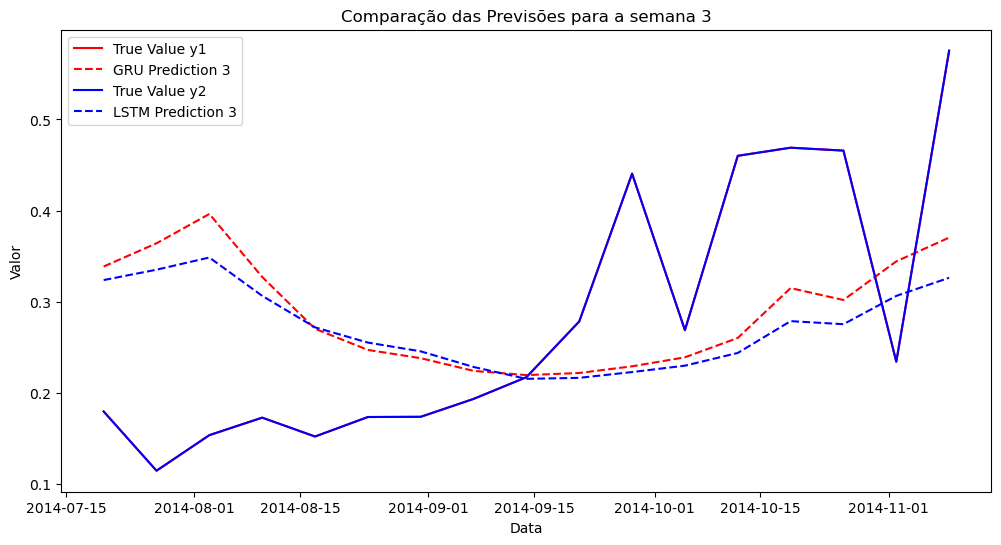

In [242]:
def plot_comparison(predictions_df, step):
    plt.figure(figsize=(12, 6))

    true_values = ['y1', 'y2', 'y3']
    model_names = ['GRU', 'LSTM']
    colors = ['red', 'blue']

    for i, model in enumerate(model_names):
        prediction_col = f'{model}_pred{step}'
        true_col = f'y{step}'

        plt.plot(predictions_df.index, predictions_df[true_col], label=f'True Value {true_values[i]}', color=colors[i])
        plt.plot(predictions_df.index, predictions_df[prediction_col], label=f'{model} Prediction {step}', linestyle='--', color=colors[i])

    plt.title(f'Comparação das Previsões para a semana {step}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

for step in range(1, 4):
    plot_comparison(results, step)

### **Avaliação dos modelos**

In [243]:
model_names = ['LSTM-Multi', 'GRU-Multi']
model_predictions = [lstm_ts_pred, gru_ts_pred]

results_df2 = evaluate_models(y_test, model_predictions, model_names)
results_df2

Model       MSE       MAE       MAPE
0  LSTM-Multi  0.024763  0.128331  51.194418
1   GRU-Multi  0.021044  0.122799  50.272265

### **Comparação de todos os modelos**

In [244]:
results_all = pd.concat([results_df, results_df2])
results_all

Model       MSE       MAE       MAPE
0        LSTM  0.018541  0.120781  56.784576
1         GRU  0.018055  0.119788  56.191442
0  LSTM-Multi  0.024763  0.128331  51.194418
1   GRU-Multi  0.021044  0.122799  50.272265